# Semi_defect_finder
반도체 공정/계측 데이터 기반 **결함 여부(불량/정상)** 이진 분류 모델 구축 노트북


[Phase 1] 전처리 파이프라인
VarianceThreshold → 상관관계 제거 → ANOVA top-K

[Phase 2] 데이터 전략별 비교  (핵심 실험: Recall 값 비교)
XGBoost, LightGBM, RF, LR 모델들로
"Normal, Undersampled, SMOTE, PCA + 위 3개" 기법들로 적용 후 비교분석

[Phase 3] 이상치 탐지 (별도 프레임)
EE / IF / LOF → Recall 비교

[Phase 4] Top 3 모델 GridSearchCV 튜닝

[Phase 5] VotingClassifier 앙상블
Phase 2~4에서 Recall 상위 모델 조합





In [24]:
# =========================================
# 1) Imports (preprocess & modeling)
# =========================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from dataclasses import dataclass
from typing import List, Optional

from sklearn.model_selection import StratifiedKFold, GroupKFold, TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    average_precision_score, precision_recall_curve, roc_auc_score,
    f1_score, precision_score, recall_score, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.base import BaseEstimator, TransformerMixin



In [4]:
# # 김태훈
# import os
# os.chdir("/home/tae-hun-kim/바탕화면/AI모델개발/Semiconductor_Quality_Prospect")
# print("cwd:", os.getcwd())
# print("exists:", os.path.exists("SECOM/uci-secom.csv"))

In [5]:
# #최정빈
# import os
# os.chdir(r"C:/Users/0726b/Semiconductor_Quality_Prospect")  
# print("cwd:", os.getcwd())
# print("exists:", os.path.exists("SECOM/uci-secom.csv"))

In [6]:
# =========================================
# 2) Load data & basic checks
# =========================================

from pathlib import Path
import pandas as pd

# 프로젝트 루트(.git) 탐색
root = Path.cwd()
while root != root.parent and not (root / ".git").exists():
    root = root.parent

csv_path = root / "SECOM" / "uci-secom.csv"
print("Resolved csv_path:", csv_path)

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

target_col = "Defect"
tool_col = "Tool_Type"

print("Target col:", target_col)
print("Tool_Type col:", tool_col)

print("Missing ratio (top 10):")
print(df.isna().mean().sort_values(ascending=False).head(16))

df.head()


Resolved csv_path: /Users/parkjunbeom/Library/CloudStorage/GoogleDrive-yrtny70127@gmail.com/내 드라이브/Colab Notebooks/Github/Project_Semiconductor/Semiconductor_Quality_Prospect/SECOM/uci-secom.csv
Shape: (1567, 592)
Columns: ['Time', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124'

Time        0        1          2          3       4      5  \
0  2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
1  2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2  2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
3  2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
4  2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   

          6       7       8  ...       581     582     583     584      585  \
0   97.6133  0.1242  1.5005  ...       NaN  0.5005  0.0118  0.0035   2.3630   
1  102.3433  0.1247  1.4966  ...  208.2045  0.5019  0.0223  0.0055   4.4447   
2   95.4878  0.1241  1.4436  ...   82.8602  0.4958  0.0157  0.0039   3.1745   
3  104.2367  0.1217  1.4882  ...   73.8432  0.4990  0.0103  0.0025   2.0544   
4  100.3967  0.1235  1.5031  ...       NaN  0.4800  0.4766  0.1045  99.3032   

      586     587     588       589  Pass/Fail  
0     NaN     NaN     NaN       NaN         -1  
1  0.0096  0.0201  0.0060  208.2045         -1  
2  0.0584  0.0484  0.0148   82.8602          1  
3  0.0202  0.0149  0.0044   73.8432         -1  
4  0.0202  0.0149  0.0044   73.8432         -1  

[5 rows x 592 columns]

Dropped Time: False


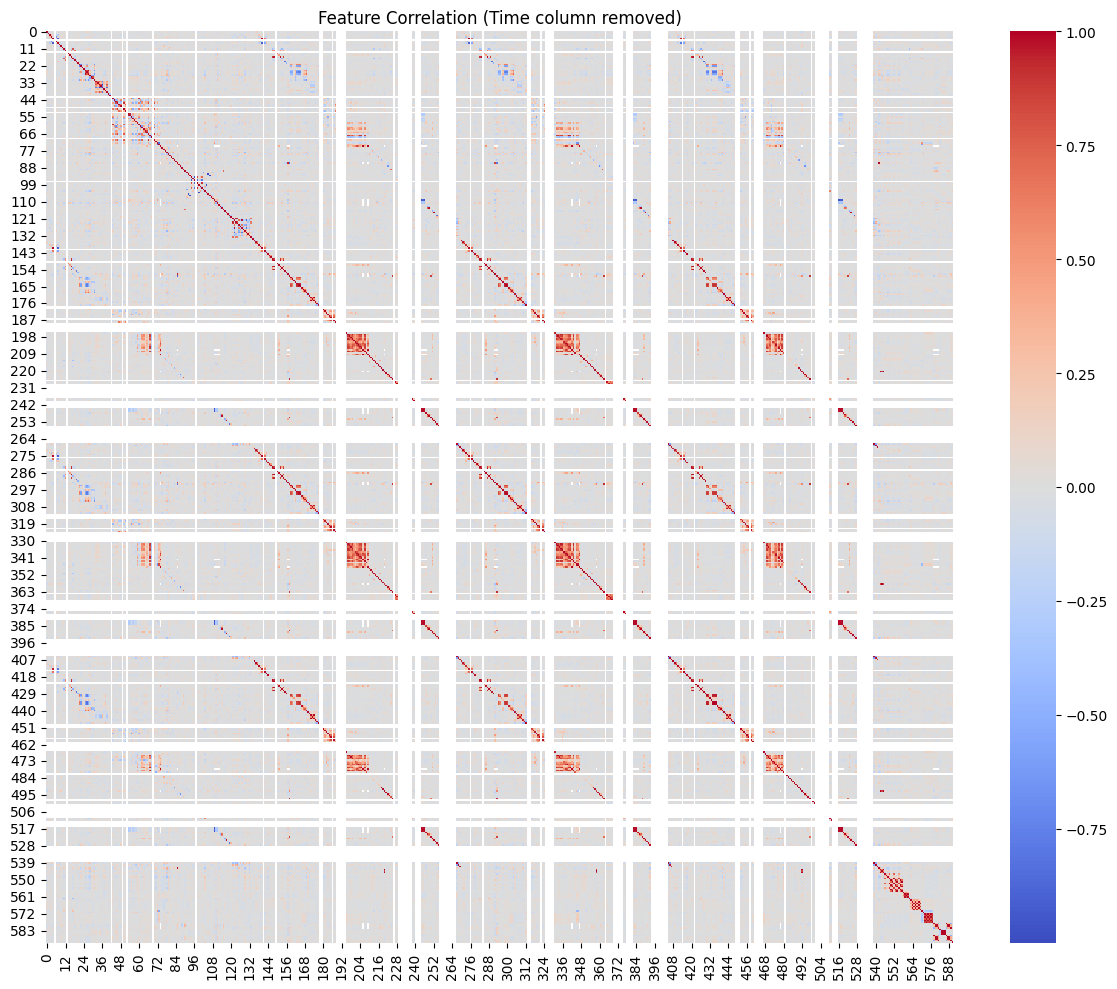

0        1          2          3       4      5         6       7  \
0  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   97.6133  0.1242   
1  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0  102.3433  0.1247   
2  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   95.4878  0.1241   
3  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0  104.2367  0.1217   
4  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0  100.3967  0.1235   

        8       9  ...       581     582     583     584      585     586  \
0  1.5005  0.0162  ...       NaN  0.5005  0.0118  0.0035   2.3630     NaN   
1  1.4966 -0.0005  ...  208.2045  0.5019  0.0223  0.0055   4.4447  0.0096   
2  1.4436  0.0041  ...   82.8602  0.4958  0.0157  0.0039   3.1745  0.0584   
3  1.4882 -0.0124  ...   73.8432  0.4990  0.0103  0.0025   2.0544  0.0202   
4  1.5031 -0.0031  ...       NaN  0.4800  0.4766  0.1045  99.3032  0.0202   

      587     588       589  Pass/Fail  
0     NaN     NaN       NaN         -1  
1  0.0201  0.0060  208.2045         -1  
2  0.0484  0.0148   82.8602          1  
3  0.0149  0.0044   73.8432         -1  
4  0.0149  0.0044   73.8432         -1  

[5 rows x 591 columns]

In [7]:
# =========================================
# 2-1) Drop Time column & correlation heatmap
# =========================================

df = df.drop(columns=["Time"], errors="ignore")
print("Dropped Time:", "Time" in df.columns)

# Numeric-only correlation
corr = df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation (Time column removed)")
plt.tight_layout()
plt.show()

df.head()


### Time 제거 → 전부 NaN/분산 0 컬럼 제거 → 숫자형 상관계수 계산 → 히트맵으로 시각화.

all_nan: 0
zero_var: 116


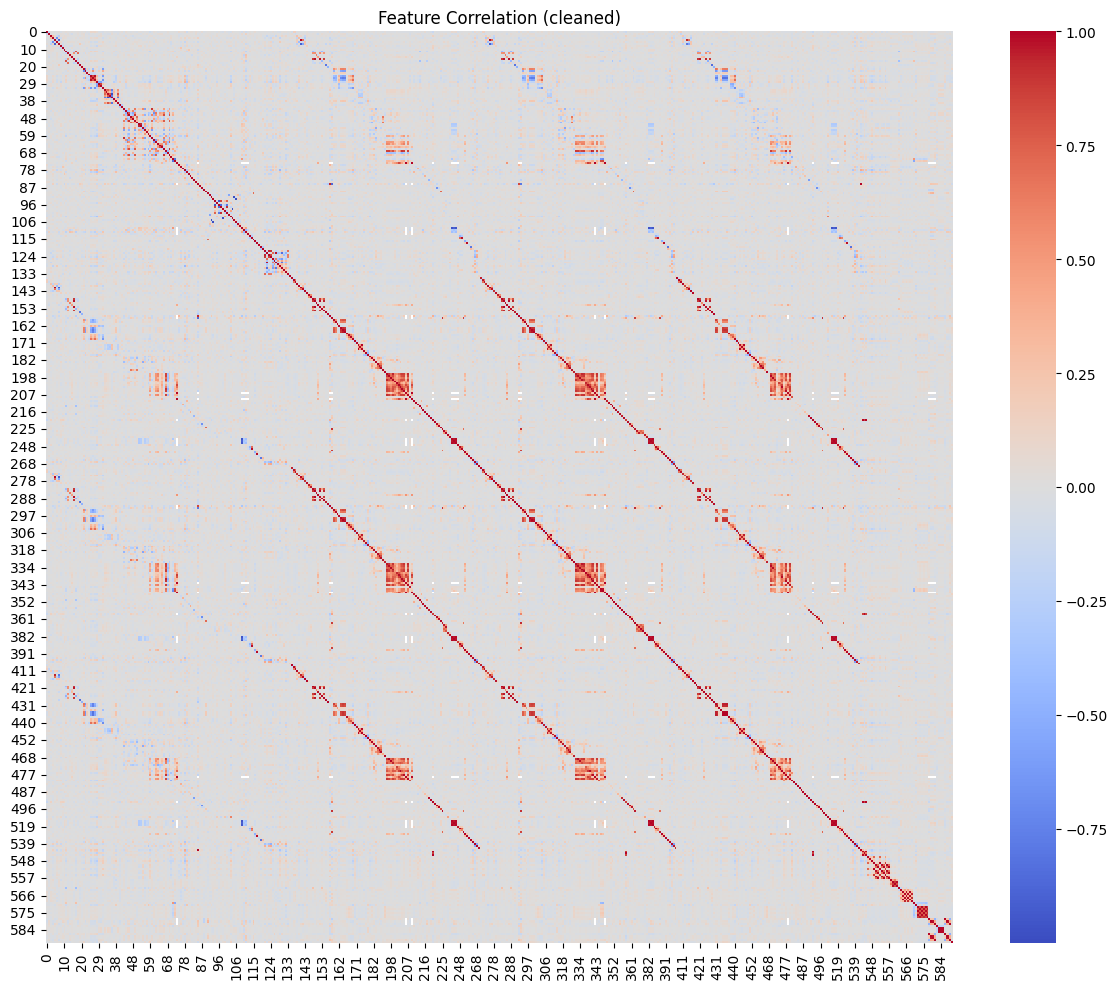

In [8]:
# df 기준
df = df.copy()

# 1) 전부 NaN 컬럼
all_nan_cols = df.columns[df.isna().all()].tolist()

# 2) 분산 0 컬럼 (값이 모두 동일)
zero_var_cols = df.columns[df.nunique(dropna=True) <= 1].tolist()

print("all_nan:", len(all_nan_cols))
print("zero_var:", len(zero_var_cols))

# 제거
drop_cols = sorted(set(all_nan_cols + zero_var_cols))
df = df.drop(columns=drop_cols)

# 다시 히트맵
corr = df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation (cleaned)")
plt.tight_layout()
plt.show()


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 475 entries, 0 to Pass/Fail
dtypes: float64(474), int64(1)
memory usage: 5.7 MB


Drop count: 194
['27', '36', '96', '104', '105', '106', '127', '140', '148', '152', '165', '174', '206', '209', '244', '245', '246', '249', '252', '271', '272', '274', '275', '277', '279', '280', '281', '282', '283', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '317', '318', '319', '320', '321', '323', '324', '332', '333', '334', '335', '338', '339', '340', '341', '342', '343', '344', '346', '347', '349', '350', '351', '352', '353', '354', '355', '357', '359', '360', '361', '362', '363', '365', '366', '376', '377', '382', '383', '384', '386', '387', '388', '389', '390', '391', '392', '393', '405', '406', '407', '408', '409', '410', '411', '415', '416', '417', '420', '421', '424', '425', '426', '427', '428', '429', '435', '436', '437', '440', '441', '442', '443', '444', '445', '446', '447', '448', '452', '453', '454', '455', '456', '457',

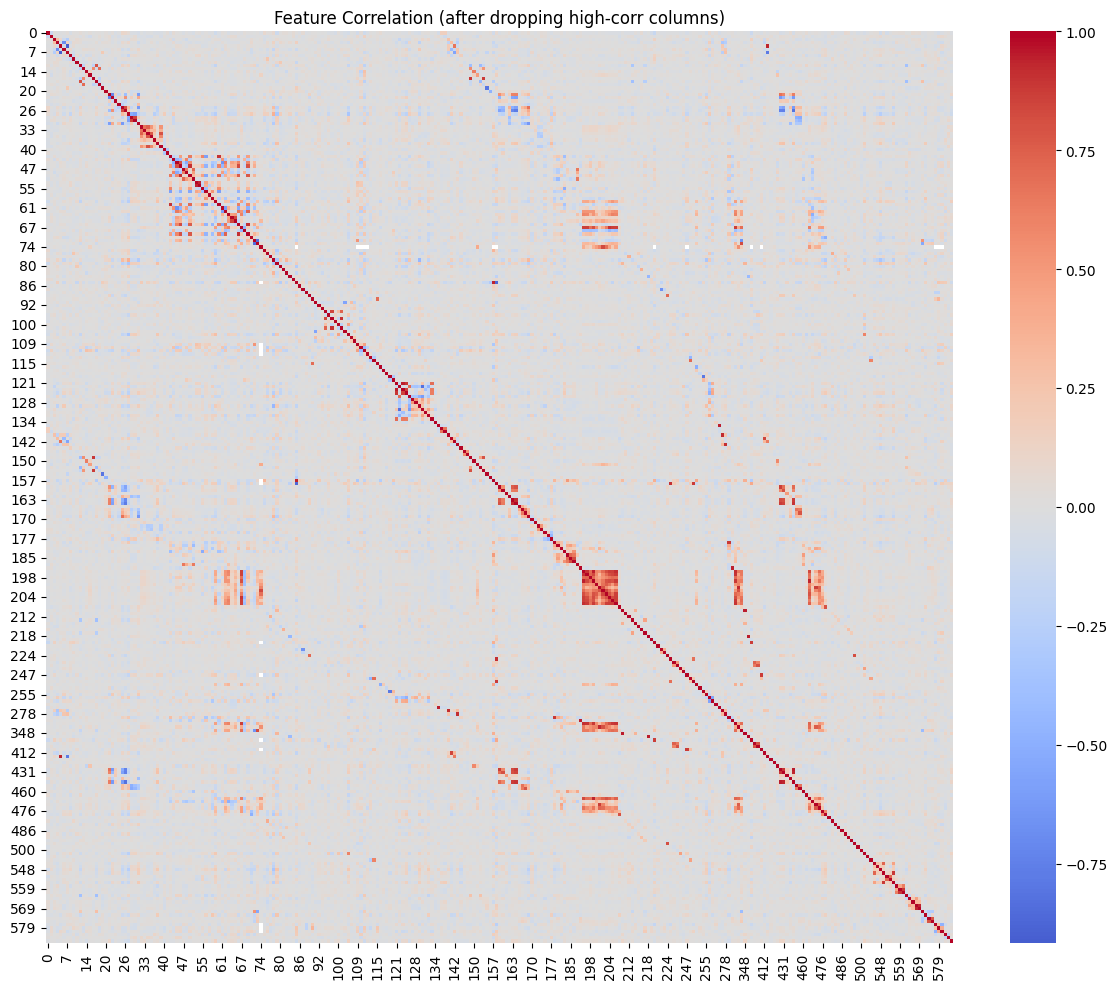

In [10]:
# 절댓값 상관계수 0.95 이상인 컬럼 제거
threshold = 0.95

# 숫자형만 상관계수
corr = df.select_dtypes(include=["number"]).corr().abs()

# 상삼각행렬만 사용 (중복 제거)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# 임계치 초과 컬럼 선택
to_drop = [col for col in upper.columns if any(upper[col] >= threshold)]

print("Drop count:", len(to_drop))

# 필요하면 목록 확인
print(to_drop)

df = df.drop(columns=to_drop)

df.info()
df.head()

# 제거 후 히트맵
corr_after = df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_after, cmap="coolwarm", center=0)
plt.title("Feature Correlation (after dropping high-corr columns)")
plt.tight_layout()
plt.show()

In [11]:
# Pass/Fail을 0/1로 변환 (-1: Pass -> 0, 1: Fail -> 1)
df["Pass/Fail"] = df["Pass/Fail"].map({-1: 0, 1: 1})

df.head(20)

0        1          2          3       4         6       7       8  \
0   3030.93  2564.00  2187.7333  1411.1265  1.3602   97.6133  0.1242  1.5005   
1   3095.78  2465.14  2230.4222  1463.6606  0.8294  102.3433  0.1247  1.4966   
2   2932.61  2559.94  2186.4111  1698.0172  1.5102   95.4878  0.1241  1.4436   
3   2988.72  2479.90  2199.0333   909.7926  1.3204  104.2367  0.1217  1.4882   
4   3032.24  2502.87  2233.3667  1326.5200  1.5334  100.3967  0.1235  1.5031   
5   2946.25  2432.84  2233.3667  1326.5200  1.5334  100.3967  0.1235  1.5287   
6   3030.27  2430.12  2230.4222  1463.6606  0.8294  102.3433  0.1247  1.5816   
7   3058.88  2690.15  2248.9000  1004.4692  0.7884  106.2400  0.1185  1.5153   
8   2967.68  2600.47  2248.9000  1004.4692  0.7884  106.2400  0.1185  1.5358   
9   3016.11  2428.37  2248.9000  1004.4692  0.7884  106.2400  0.1185  1.5381   
10  2994.05  2548.21  2195.1222  1046.1468  1.3204  103.3400  0.1223  1.5144   
11  2928.84  2479.40  2196.2111  1605.7578  0.9959   97.9156  0.1257  1.4690   
12  2920.07  2507.40  2195.1222  1046.1468  1.3204  103.3400  0.1223  1.5310   
13  3051.44  2529.27  2184.4333   877.6266  1.4668  107.8711  0.1240  1.5236   
14  2963.97  2629.48  2224.6222   947.7739  1.2924  104.8489  0.1197  1.4474   
15  2988.31  2546.26  2224.6222   947.7739  1.2924  104.8489  0.1197  1.5465   
16  3028.02  2560.87  2270.2556  1258.4558  1.3950  104.8078  0.1207  1.4368   
17  3032.73  2517.79  2270.2556  1258.4558  1.3950  104.8078  0.1207  1.5537   
18  3040.34  2501.16  2207.3889   962.5317  1.2043  104.0311  0.1210  1.5481   
19  2988.30  2519.05  2208.8556  1157.7224  1.5509  107.8022  0.1233  1.5362   

         9      10  ...       570     571       572     573     578     579  \
0   0.0162 -0.0034  ...  533.8500  2.1113    8.9500  0.3157     NaN     NaN   
1  -0.0005 -0.0148  ...  535.0164  2.4335    5.9200  0.2653  0.0096  0.0201   
2   0.0041  0.0013  ...  535.0245  2.0293   11.2100  0.1882  0.0584  0.0484   
3  -0.0124 -0.0033  ...  530.5682  2.0253    9.3300  0.1738  0.0202  0.0149   
4  -0.0031 -0.0072  ...  532.0155  2.0275    8.8300  0.2224     NaN     NaN   
5   0.0167  0.0055  ...  534.2091  2.3236    8.9100  0.3201  0.0342  0.0151   
6  -0.0270  0.0105  ...  541.9036  2.4229    6.4800  0.2027     NaN     NaN   
7   0.0157  0.0007  ...  493.0054  2.2008  278.1900  0.3540  0.0204  0.0194   
8   0.0111 -0.0066  ...  535.1818  2.2170    7.0900  0.3168  0.0111  0.0124   
9   0.0159  0.0049  ...  533.4200  2.2598    3.5400  0.1676  0.0212  0.0191   
10 -0.0190  0.0013  ...  532.1764  1.8715    9.5699  0.2723  0.0355  0.0205   
11  0.0170 -0.0154  ...  533.7464  2.1865    7.7400  0.2800  0.0370  0.0279   
12 -0.0259  0.0216  ...  530.1800  1.9690    9.9500  0.1291  0.0188  0.0098   
13 -0.0209 -0.0031  ...  533.2464  2.2354    9.9300  0.2785     NaN     NaN   
14  0.0144 -0.0119  ...  532.6446  2.2808   11.4200  0.3692  0.0202  0.0289   
15  0.0250 -0.0024  ...  536.1118  2.3120    8.5300  0.3049  0.0174  0.0174   
16  0.0150 -0.0037  ...  537.8145  2.1113    8.4300  0.2364  0.0184  0.0151   
17  0.0220 -0.0027  ...  531.8418  2.1849   10.2600  0.4839     NaN     NaN   
18 -0.0367  0.0014  ...  532.2673  2.2820    6.0000  0.3148     NaN     NaN   
19 -0.0259 -0.0179  ...  534.6455  2.0642    7.8100  0.2811  0.0229  0.0108   

         581     582     583  Pass/Fail  
0        NaN  0.5005  0.0118          0  
1   208.2045  0.5019  0.0223          0  
2    82.8602  0.4958  0.0157          1  
3    73.8432  0.4990  0.0103          0  
4        NaN  0.4800  0.4766          0  
5    44.0077  0.4949  0.0189          0  
6        NaN  0.5010  0.0143          0  
7    95.0310  0.4984  0.0106          0  
8   111.6525  0.4993  0.0172          0  
9    90.2294  0.4967  0.0152          0  
10   57.8122  0.4925  0.0158          1  
11   75.5077  0.4987  0.0427          1  
12   52.2039  0.4950  0.0153          0  
13       NaN  0.5034  0.0151          0  
14  142.9080  0.5077  0.0094          1

158    0.911934
157    0.911934
220    0.855775
85     0.855775
358    0.855775
109    0.649649
111    0.649649
110    0.649649
581    0.605616
579    0.605616
578    0.605616
345    0.506701
73     0.506701
72     0.506701
247    0.456286
112    0.456286
385    0.456286
565    0.174218
569    0.174218
564    0.174218
563    0.174218
562    0.174218
548    0.165922
546    0.165922
547    0.165922
549    0.165922
551    0.165922
555    0.165922
550    0.165922
90     0.032546
dtype: float64


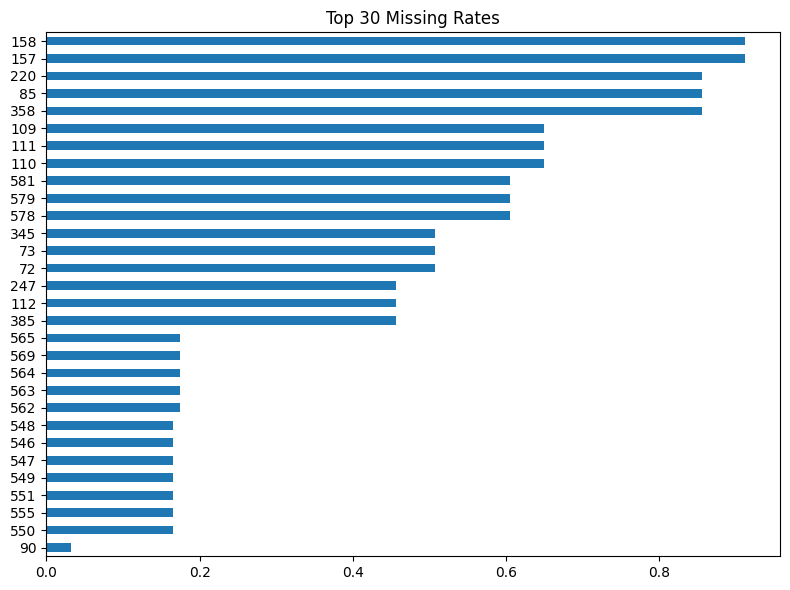

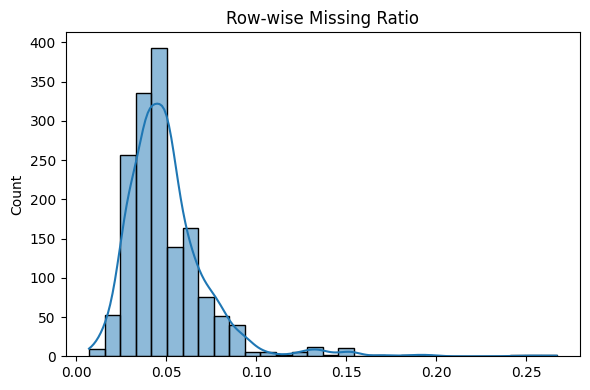

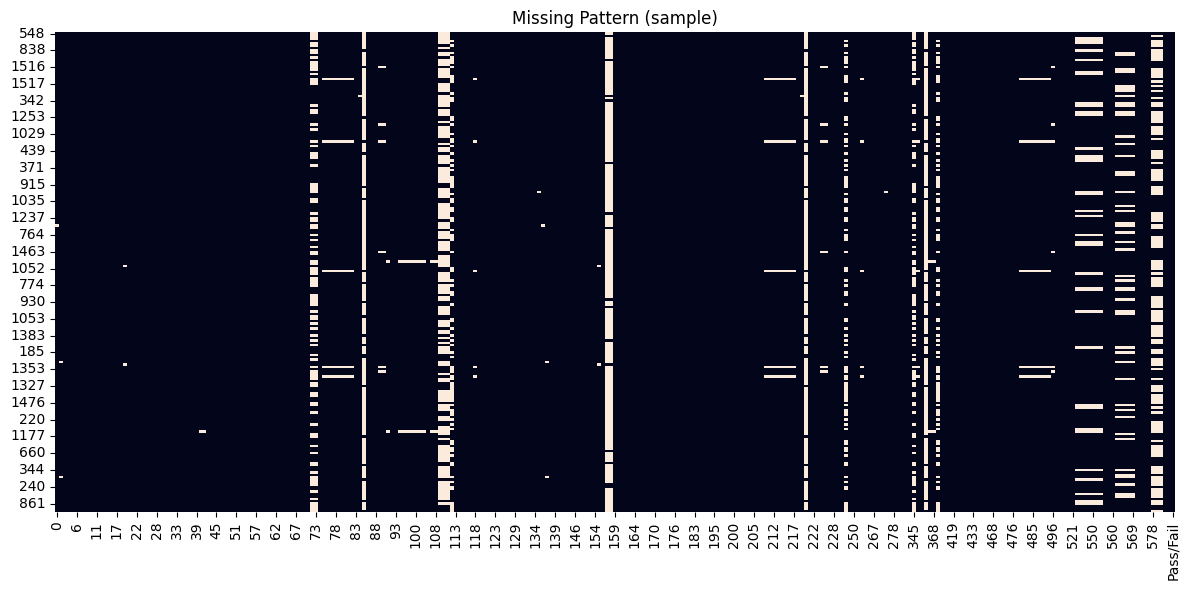

                  0         1         2         3         4         6  \
Pass/Fail                                                               
0          0.004101  0.004101  0.009569  0.009569  0.009569  0.009569   
1          0.000000  0.009615  0.000000  0.000000  0.000000  0.000000   

                  7         8         9        10  ...  570  571  572  573  \
Pass/Fail                                          ...                       
0          0.006152  0.001367  0.001367  0.001367  ...  0.0  0.0  0.0  0.0   
1          0.000000  0.000000  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   

                578       579       581       582       583  Pass/Fail  
Pass/Fail                                                               
0          0.608339  0.608339  0.608339  0.000684  0.000684        0.0  
1          0.567308  0.567308  0.567308  0.000000  0.000000        0.0  

[2 rows x 281 columns]


In [12]:

# 1) 컬럼별 결측률 상위 30개
missing_rate = df.isna().mean().sort_values(ascending=False)
print(missing_rate.head(30))

plt.figure(figsize=(8, 6))
missing_rate.head(30).plot(kind="barh")
plt.title("Top 30 Missing Rates")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2) 행별 결측률 분포
row_missing = df.isna().mean(axis=1)

plt.figure(figsize=(6, 4))
sns.histplot(row_missing, bins=30, kde=True)
plt.title("Row-wise Missing Ratio")
plt.tight_layout()
plt.show()

# 3) 결측 패턴 히트맵 (샘플 200행)
sample = df.sample(min(200, len(df)), random_state=42)
plt.figure(figsize=(12, 6))
sns.heatmap(sample.isna(), cbar=False)
plt.title("Missing Pattern (sample)")
plt.tight_layout()
plt.show()

# 4) 타깃별 결측률 비교 (Pass/Fail 컬럼이 있을 때)
if "Pass/Fail" in df.columns:
    missing_by_target = df.groupby("Pass/Fail").apply(lambda x: x.isna().mean())
    print(missing_by_target.head())


In [13]:
# # 결측률 0.4 이상 컬럼 제거
# threshold = 0.04
# missing_rate = df.isna().mean()
# drop_cols = missing_rate[missing_rate >= threshold].index.tolist()

# print("Drop count:", len(drop_cols))
# print(drop_cols)

# df = df.drop(columns=drop_cols)

# # 확인
# df.info()


In [14]:
# # 1) 컬럼별 결측률 상위 30개
# missing_rate = df.isna().mean().sort_values(ascending=False)
# print(missing_rate.head(30))

# plt.figure(figsize=(8, 6))
# missing_rate.head(30).plot(kind="barh")
# plt.title("Top 30 Missing Rates")
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

# # 2) 행별 결측률 분포
# row_missing = df.isna().mean(axis=1)

# plt.figure(figsize=(6, 4))
# sns.histplot(row_missing, bins=30, kde=True)
# plt.title("Row-wise Missing Ratio")
# plt.tight_layout()
# plt.show()

# # 3) 결측 패턴 히트맵 (샘플 200행)
# sample = df.sample(min(200, len(df)), random_state=42)
# plt.figure(figsize=(12, 6))
# sns.heatmap(sample.isna(), cbar=False)
# plt.title("Missing Pattern (sample)")
# plt.tight_layout()
# plt.show()

# # 4) 타깃별 결측률 비교 (Pass/Fail 컬럼이 있을 때)
# if "Pass/Fail" in df.columns:
#     missing_by_target = df.groupby("Pass/Fail").apply(lambda x: x.isna().mean())
#     print(missing_by_target.head())


# Visualization

In [15]:
# 1) 컬럼 타입 분리
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(exclude=["number"]).columns.tolist()

print("Numeric cols:", len(num_cols))
print("Categorical cols:", len(cat_cols))

# 2) 숫자형: 분산 큰 Top 10 (분포/박스플롯 추천)
num_var = df[num_cols].var().sort_values(ascending=False)
print("\nTop variance numeric cols:")
print(num_var.head(10))

# 3) 숫자형: 왜도 큰 Top 10 (로그변환 전/후 비교 추천)
num_skew = df[num_cols].skew().sort_values(ascending=False)
print("\nTop skew numeric cols:")
print(num_skew.head(10))

# 4) 결측률 높은 컬럼 Top 10 (결측 패턴/타깃 비교 추천)
missing_rate = df.isna().mean().sort_values(ascending=False)
print("\nTop missing rate cols:")
print(missing_rate.head(10))

# 5) 상관 높은 컬럼 쌍 Top 10 (산점도 추천)
corr = df[num_cols].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr_pairs = (
    upper.stack()
         .sort_values(ascending=False)
         .head(10)
)
print("\nTop correlated pairs:")
print(high_corr_pairs)

# 6) 범주형: 값 개수 많은 Top 10 (막대그래프/파이 추천)
if cat_cols:
    cat_card = df[cat_cols].nunique().sort_values(ascending=False)
    print("\nTop cardinality categorical cols:")
    print(cat_card.head(10))


Numeric cols: 281
Categorical cols: 0

Top variance numeric cols:
162    4.294927e+07
161    1.797120e+07
24     8.425610e+06
23     1.904848e+06
159    9.663736e+05
21     3.929060e+05
160    3.304049e+05
204    3.193394e+05
3      1.950915e+05
225    1.876363e+05
dtype: float64

Top skew numeric cols:
74     39.509493
117    38.005963
16     37.034763
185    30.699402
147    29.428439
154    27.705929
202    24.677828
187    24.508675
583    24.409675
251    21.587996
dtype: float64

Top missing rate cols:
158    0.911934
157    0.911934
220    0.855775
85     0.855775
358    0.855775
109    0.649649
111    0.649649
110    0.649649
581    0.605616
579    0.605616
dtype: float64

Top correlated pairs:
218  356    0.949903
210  348    0.949733
430  434    0.948040
135  270    0.946474
195  331    0.945308
121  123    0.942283
196  199    0.941986
565  569    0.939885
4    413    0.938416
199  471    0.938281
dtype: float64


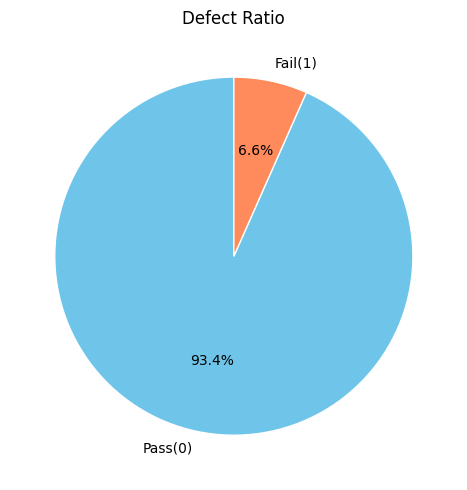

In [16]:
# 결함(1) / 정상(0) 비율 원그래프
counts = df["Pass/Fail"].value_counts().sort_index()
labels = ["Pass(0)", "Fail(1)"]
colors = ["#6EC5E9", "#FF8A5B"]  # 파스텔 블루/코랄

plt.figure(figsize=(5, 5))
plt.pie(
    counts,
    labels=labels,
    colors=colors,
    autopct="%.1f%%",
    startangle=90,
    wedgeprops={"edgecolor": "white", "linewidth": 1}
)
plt.title("Defect Ratio")
plt.tight_layout()
plt.show()



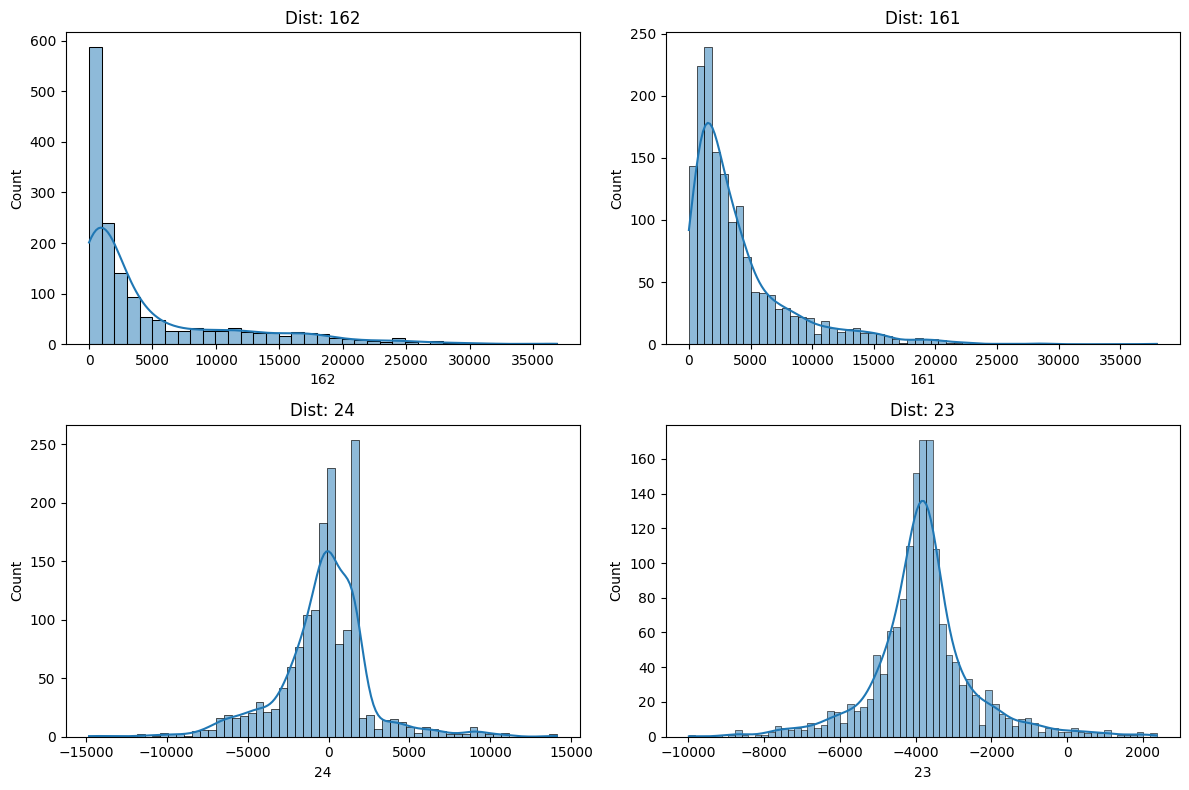

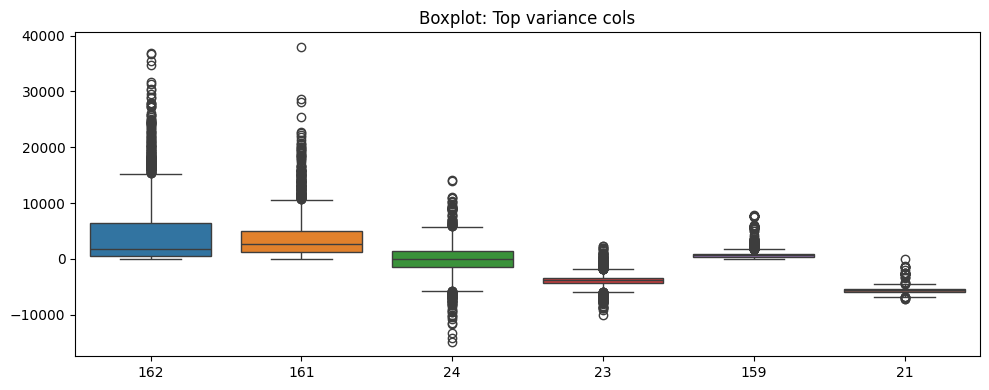

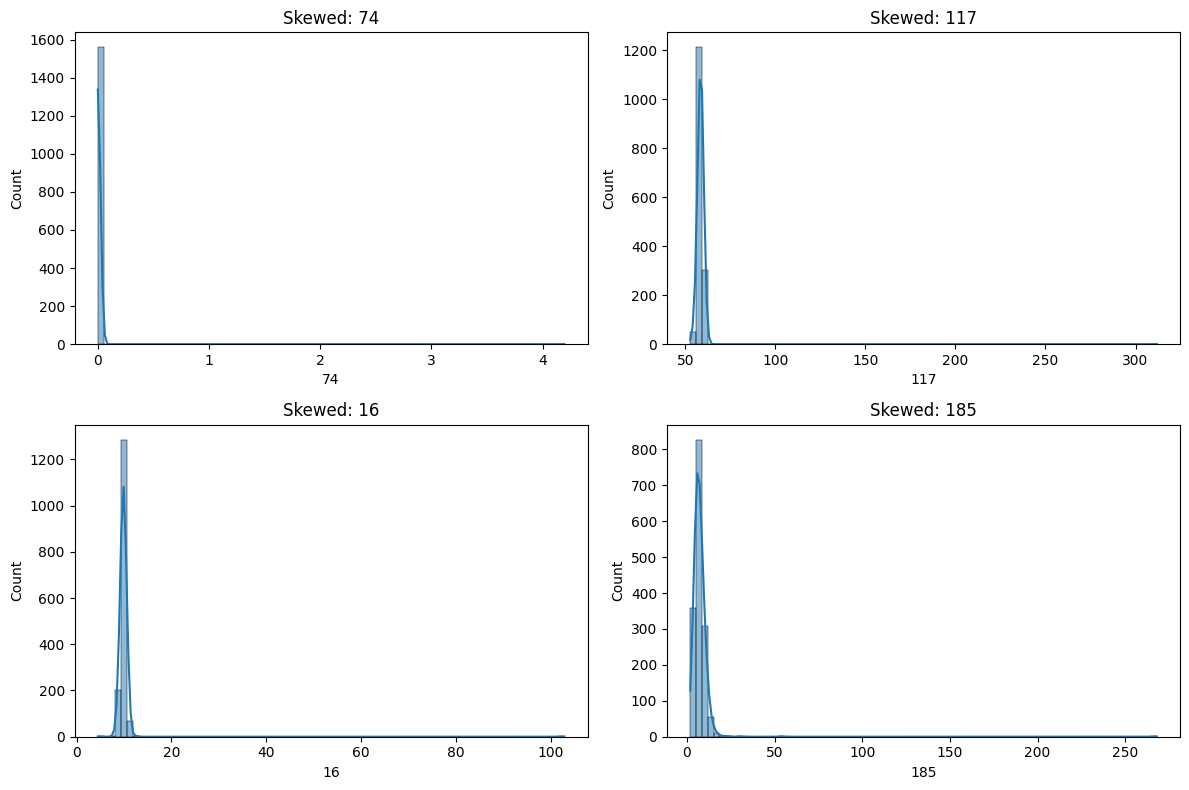

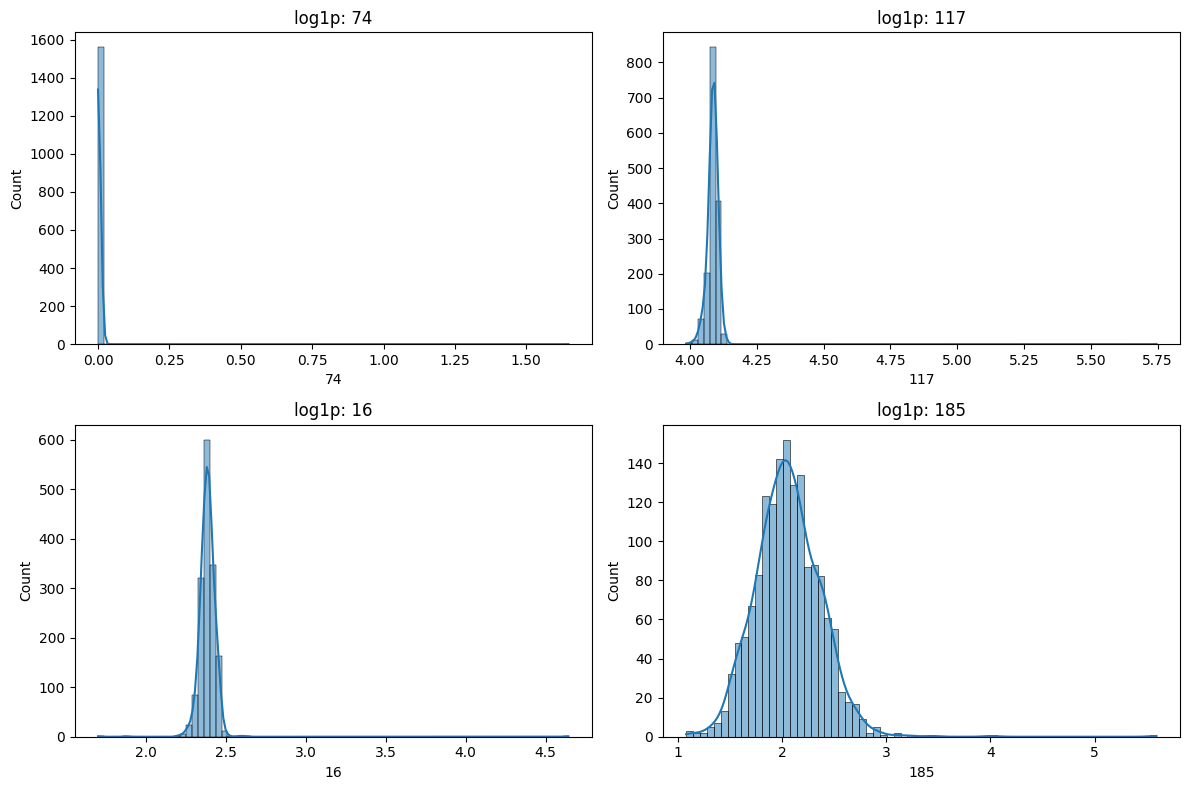

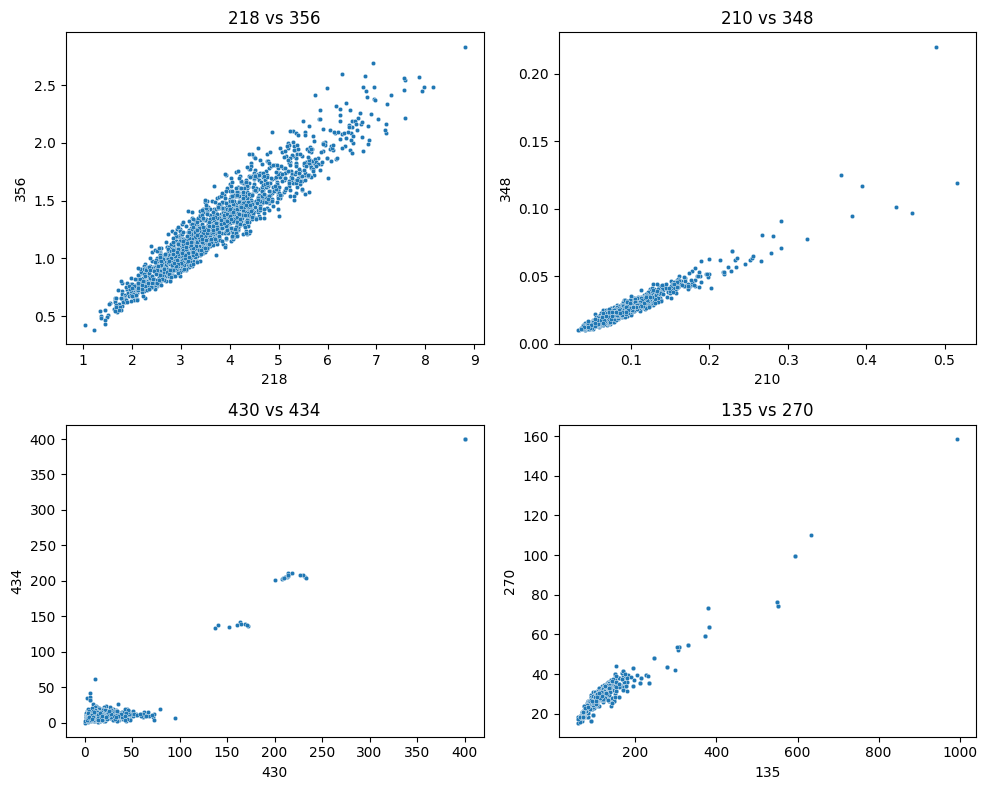

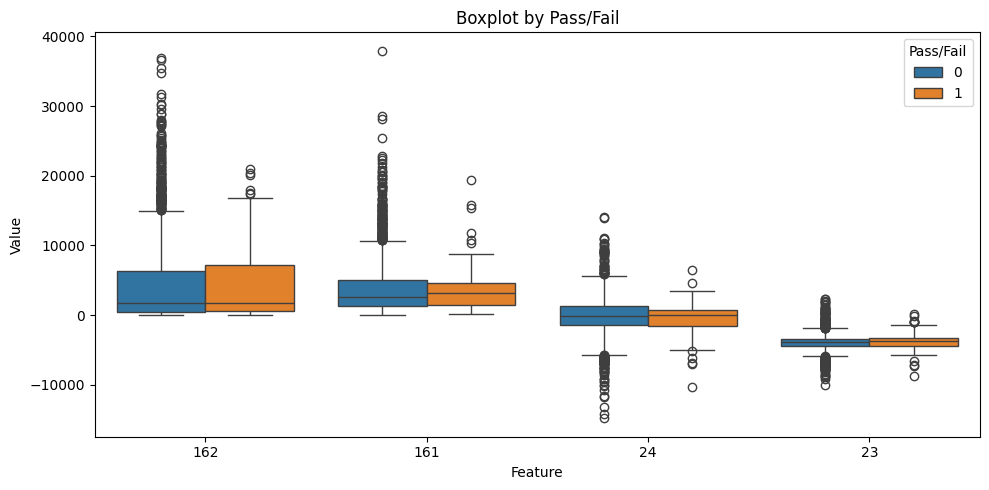

In [17]:
# 컬럼명이 문자열이라 문자열로 지정
top_var_cols = ["162","161","24","23","159","21","160","204","3","225"]
skew_cols = ["74","117","16","185"]

# 1) 분산 큰 컬럼 분포 + 박스플롯
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, col in zip(axes.flatten(), top_var_cols[:4]):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Dist: {col}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(data=df[top_var_cols[:6]])
plt.title("Boxplot: Top variance cols")
plt.tight_layout()
plt.show()

# 2) 왜도 큰 컬럼: 원본 vs 로그 분포
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, col in zip(axes.flatten(), skew_cols):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Skewed: {col}")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, col in zip(axes.flatten(), skew_cols):
    sns.histplot(np.log1p(df[col]), kde=True, ax=ax)
    ax.set_title(f"log1p: {col}")
plt.tight_layout()
plt.show()

# 3) 상관 높은 컬럼 쌍 산점도 (상위 4쌍 자동)
corr = df.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
top_pairs = upper.stack().sort_values(ascending=False).head(4).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, (c1, c2) in zip(axes.flatten(), top_pairs):
    sns.scatterplot(x=df[c1], y=df[c2], ax=ax, s=10)
    ax.set_title(f"{c1} vs {c2}")
plt.tight_layout()
plt.show()

# 4) 타깃(0/1) 기준 박스플롯 (Pass/Fail 컬럼이 있을 때)
if "Pass/Fail" in df.columns:
    target_cols = top_var_cols[:4]
    plt.figure(figsize=(10, 5))
    df_melt = df.melt(id_vars="Pass/Fail", value_vars=target_cols, var_name="Feature", value_name="Value")
    sns.boxplot(data=df_melt, x="Feature", y="Value", hue="Pass/Fail")
    plt.title("Boxplot by Pass/Fail")
    plt.tight_layout()
    plt.show()


In [18]:
target = "Pass/Fail"
num_cols = df.select_dtypes(include=["number"]).columns
num_cols = [c for c in num_cols if c != target]

# 그룹 분리
g0 = df[df[target] == 0]
g1 = df[df[target] == 1]

def cohen_d(col):
    x0 = g0[col].dropna()
    x1 = g1[col].dropna()
    if len(x0) < 2 or len(x1) < 2:
        return np.nan
    n0, n1 = len(x0), len(x1)
    s0, s1 = x0.std(ddof=1), x1.std(ddof=1)
    s_pooled = np.sqrt(((n0-1)*s0**2 + (n1-1)*s1**2) / (n0+n1-2))
    if s_pooled == 0 or np.isnan(s_pooled):
        return np.nan
    return (x1.mean() - x0.mean()) / s_pooled

scores = {col: cohen_d(col) for col in num_cols}
sep = pd.Series(scores).abs().sort_values(ascending=False)

print("Top 10 by separation (|Cohen's d|):")
print(sep.head(10))


Top 10 by separation (|Cohen's d|):
59     0.631888
103    0.613731
510    0.532625
348    0.523349
158    0.518944
111    0.503717
431    0.490669
85     0.481719
434    0.454736
430    0.446322
dtype: float64


Top 10 by separation (|Cohen's d|):
59     0.631888
103    0.613731
510    0.532625
348    0.523349
158    0.518944
111    0.503717
431    0.490669
85     0.481719
434    0.454736
430    0.446322
dtype: float64


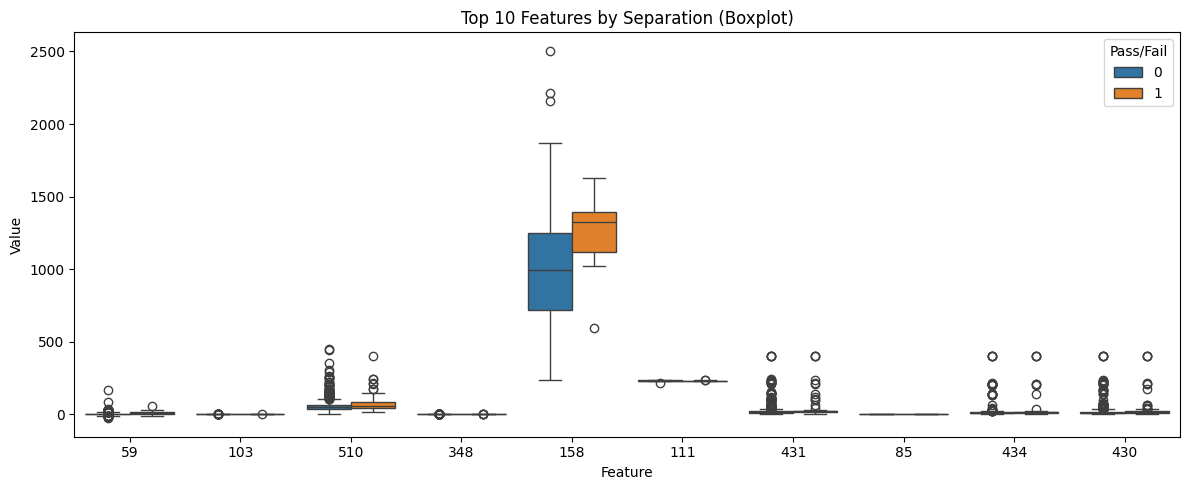

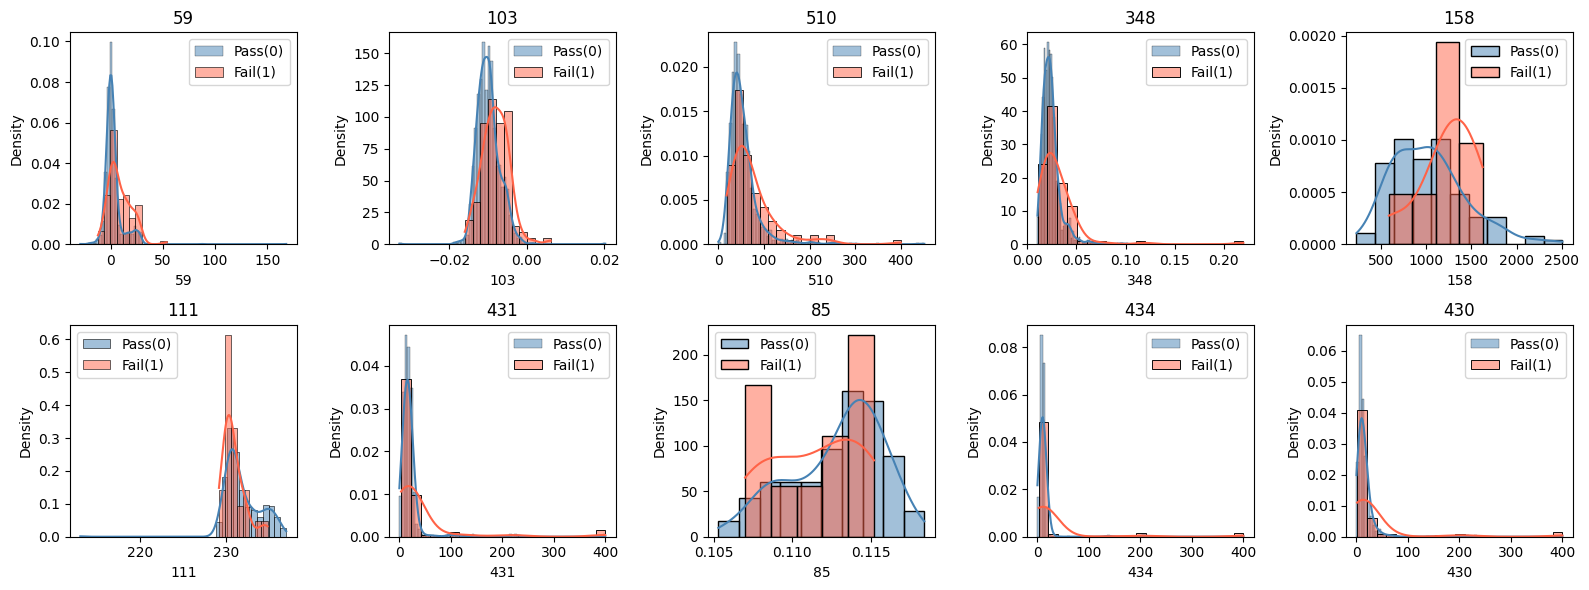

In [19]:
target = "Pass/Fail"
num_cols = df.select_dtypes(include=["number"]).columns
num_cols = [c for c in num_cols if c != target]

g0 = df[df[target] == 0]
g1 = df[df[target] == 1]

def cohen_d(col):
    x0 = g0[col].dropna()
    x1 = g1[col].dropna()
    if len(x0) < 2 or len(x1) < 2:
        return np.nan
    n0, n1 = len(x0), len(x1)
    s0, s1 = x0.std(ddof=1), x1.std(ddof=1)
    s_pooled = np.sqrt(((n0-1)*s0**2 + (n1-1)*s1**2) / (n0+n1-2))
    if s_pooled == 0 or np.isnan(s_pooled):
        return np.nan
    return (x1.mean() - x0.mean()) / s_pooled

scores = {col: cohen_d(col) for col in num_cols}
sep = pd.Series(scores).abs().sort_values(ascending=False)
top10 = sep.head(10).index.tolist()

print("Top 10 by separation (|Cohen's d|):")
print(sep.head(10))

# 1) 박스플롯
plt.figure(figsize=(12, 5))
df_melt = df.melt(id_vars=target, value_vars=top10, var_name="Feature", value_name="Value")
sns.boxplot(data=df_melt, x="Feature", y="Value", hue=target)
plt.title("Top 10 Features by Separation (Boxplot)")
plt.tight_layout()
plt.show()

# 2) 히스토그램
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
for ax, col in zip(axes.flatten(), top10):
    sns.histplot(g0[col], color="steelblue", label="Pass(0)", kde=True, ax=ax, stat="density", alpha=0.5)
    sns.histplot(g1[col], color="tomato", label="Fail(1)", kde=True, ax=ax, stat="density", alpha=0.5)
    ax.set_title(str(col))
    ax.legend()
plt.tight_layout()
plt.show()


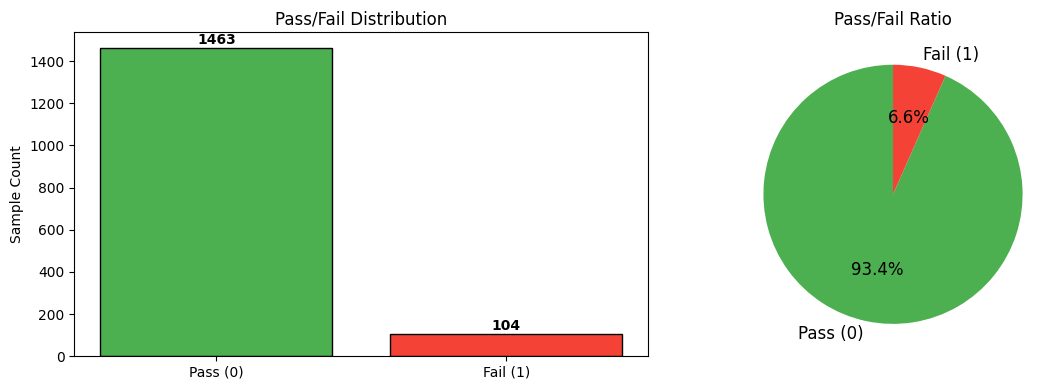

Pass: 1463 (93.4%)
Fail: 104 (6.6%)
Imbalance ratio: 1:14
KDE visualization: top 24 features by effect size
Top 5: ['59', '103', '510', '348', '431']


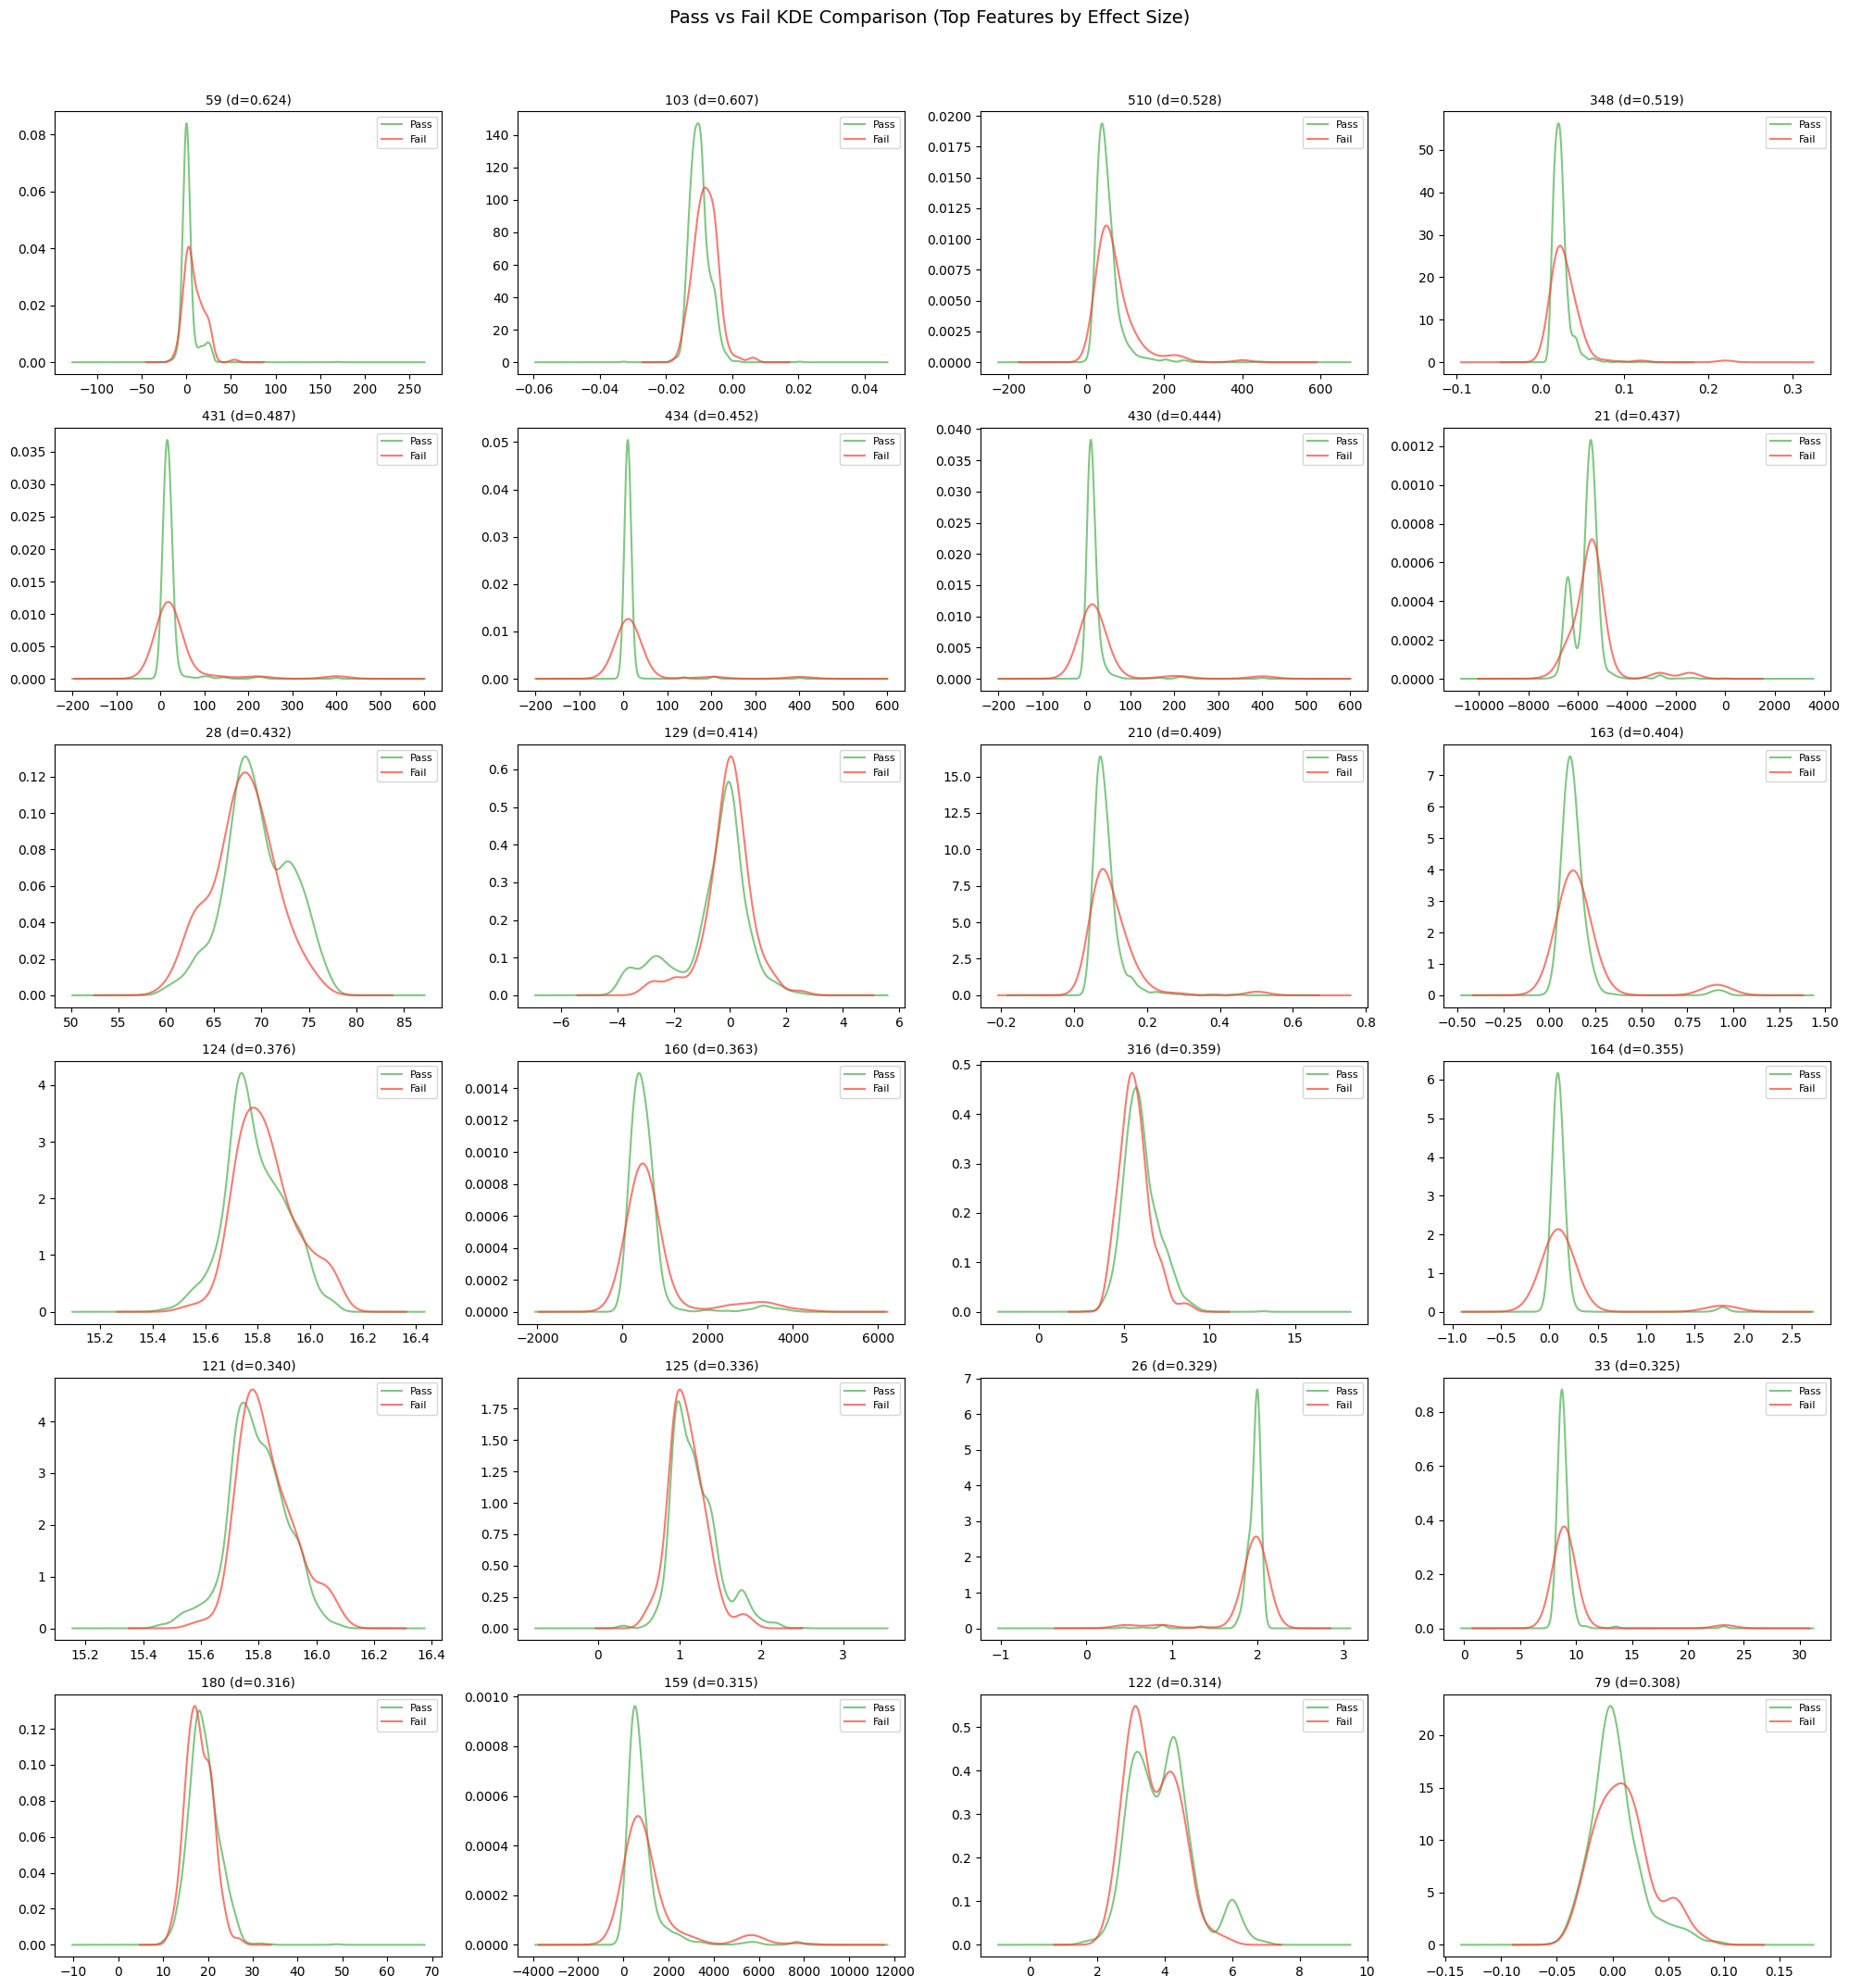

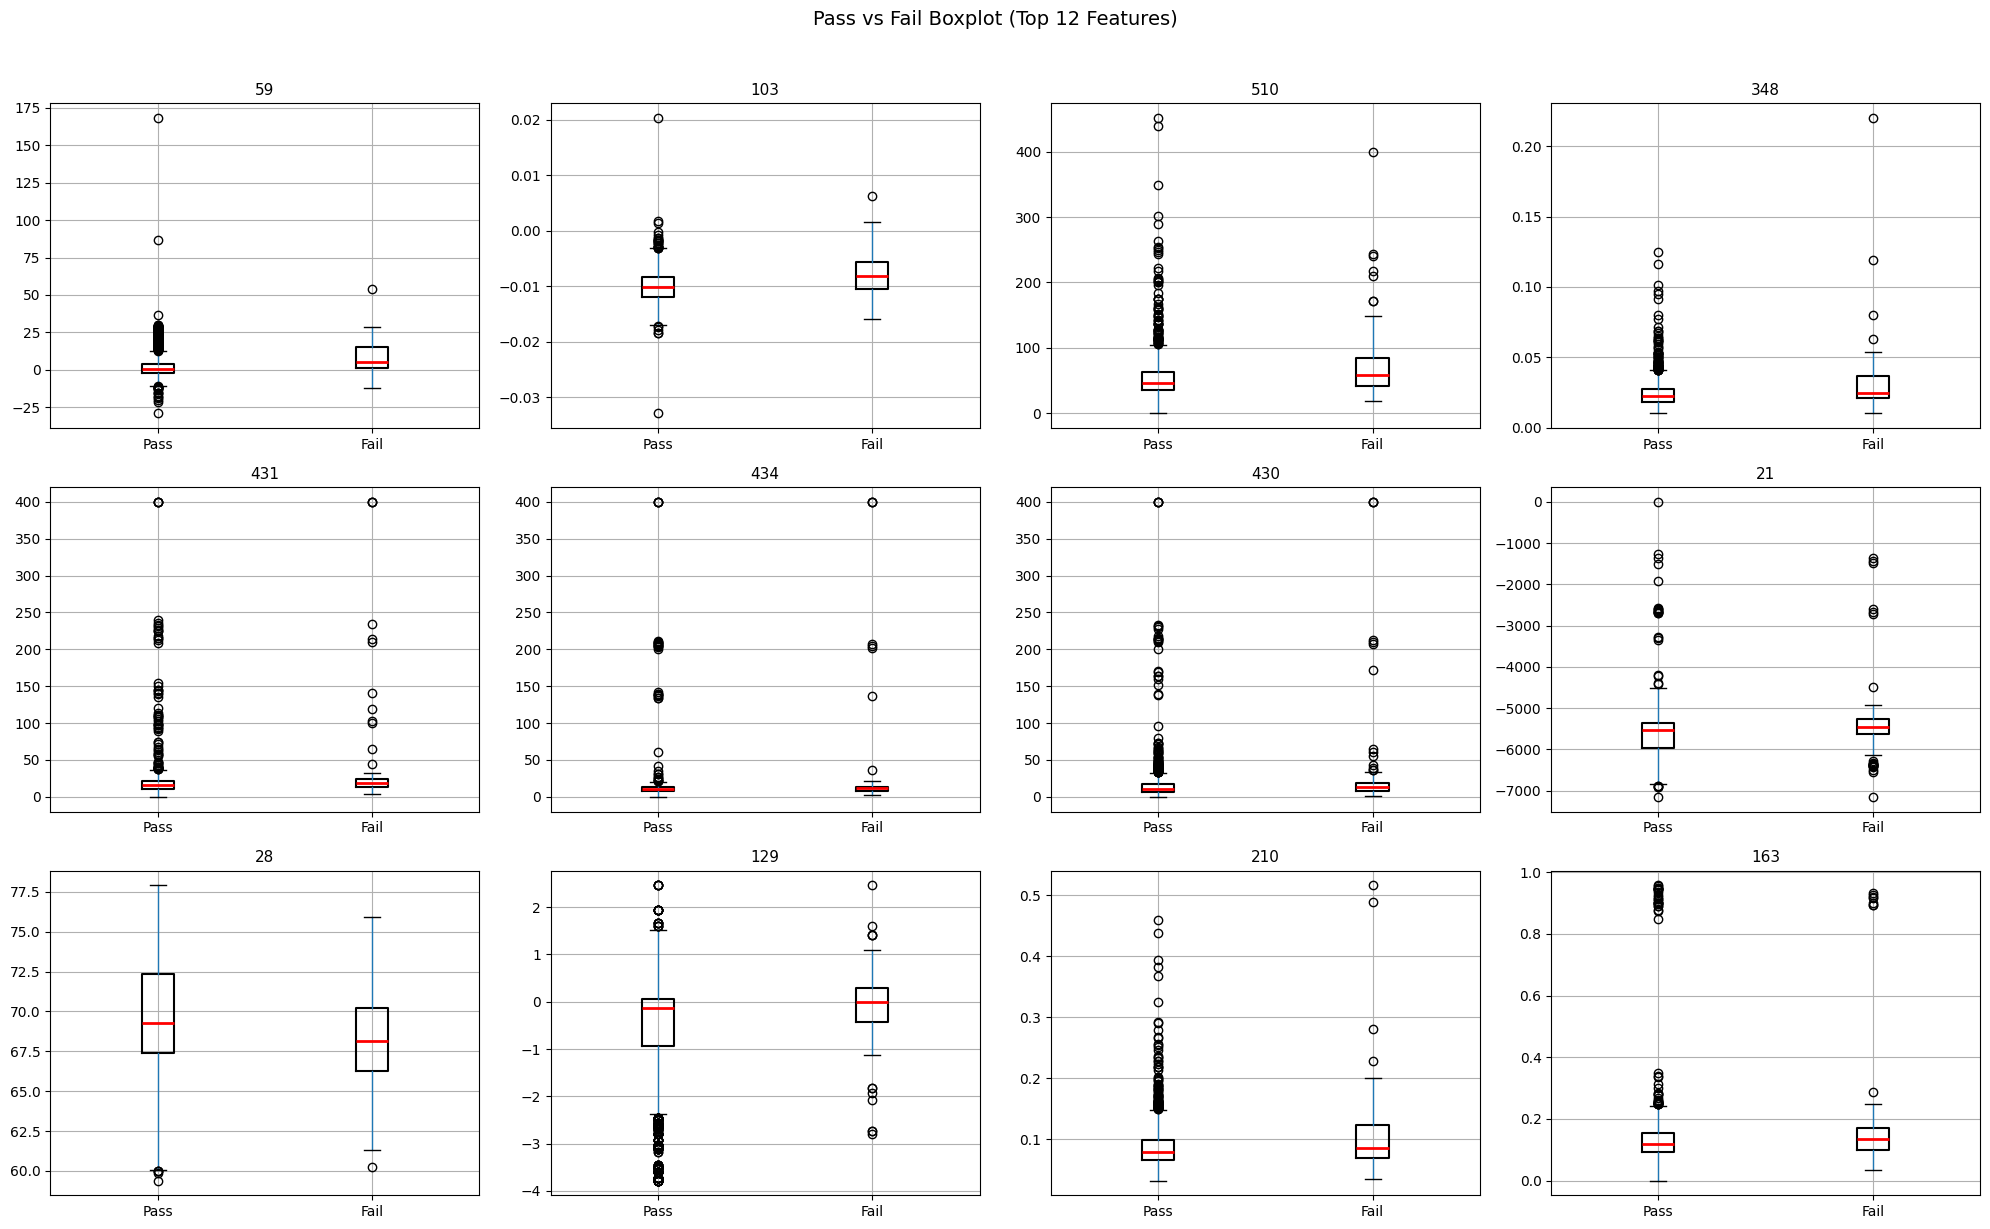

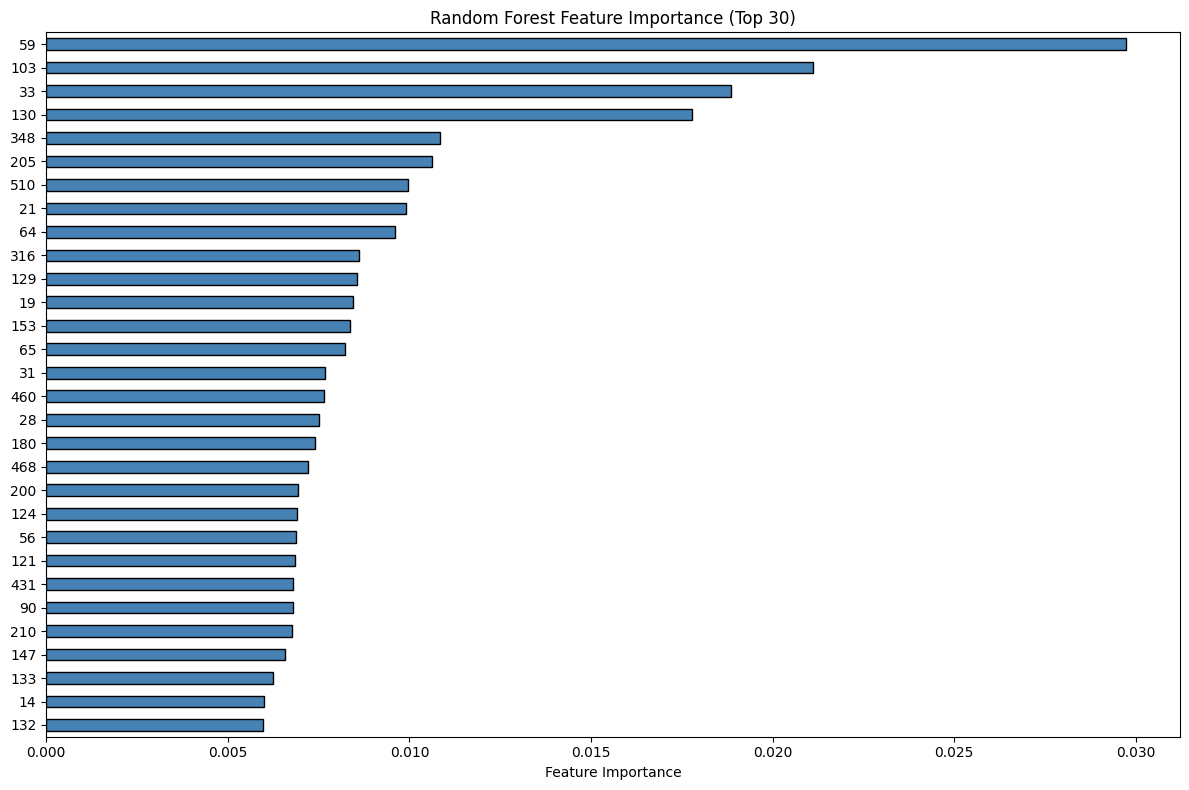

=== Top 10 Importance ===
     59: 0.0297
    103: 0.0211
     33: 0.0188
    130: 0.0178
    348: 0.0109
    205: 0.0106
    510: 0.0100
     21: 0.0099
     64: 0.0096
    316: 0.0086


In [20]:
# =========================================
# 0) Feature Columns 정의
# =========================================
feat_cols = df.select_dtypes(include=["number"]).columns
feat_cols = [c for c in feat_cols if c != "Pass/Fail"]

# =========================================
# 4) Target Distribution (Pass/Fail Ratio)
# =========================================
counts = df['Pass/Fail'].value_counts().sort_index()
labels = ['Pass (0)', 'Fail (1)']
colors = ['#4CAF50', '#F44336']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(labels, counts.values, color=colors, edgecolor='black')
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 20, f'{v}', ha='center', fontweight='bold')
axes[0].set_ylabel('Sample Count')
axes[0].set_title('Pass/Fail Distribution')

axes[1].pie(counts.values, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Pass/Fail Ratio')

plt.tight_layout()
plt.show()

print(f'Pass: {counts.iloc[0]} ({counts.iloc[0]/len(df)*100:.1f}%)')
print(f'Fail: {counts.iloc[1]} ({counts.iloc[1]/len(df)*100:.1f}%)')
print(f'Imbalance ratio: 1:{counts.iloc[0]//counts.iloc[1]}')


# =========================================
# 4-1) Pass vs Fail KDE Comparison (Top Features)
# =========================================
valid_cols = [c for c in feat_cols if df[c].isna().mean() <= 0.4]

pass_data = df.loc[df['Pass/Fail'] == 0, valid_cols]
fail_data = df.loc[df['Pass/Fail'] == 1, valid_cols]

mean_diff = (fail_data.mean() - pass_data.mean()).abs()
pooled_std = df[valid_cols].std().replace(0, np.nan)
effect_size = (mean_diff / pooled_std).dropna().sort_values(ascending=False)

top_features = effect_size.head(24).index.tolist()
print(f'KDE visualization: top {len(top_features)} features by effect size')
print(f'Top 5: {top_features[:5]}')

n_cols = 4
n_rows = math.ceil(len(top_features) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3.5))
axes = axes.flatten()

for i, col in enumerate(top_features):
    ax = axes[i]
    for label, name, color in [(0, 'Pass', '#4CAF50'), (1, 'Fail', '#F44336')]:
        subset = df.loc[df['Pass/Fail'] == label, col].dropna()
        if len(subset) > 1:
            subset.plot.kde(ax=ax, label=name, color=color, alpha=0.7)
    ax.set_title(f'{col} (d={effect_size[col]:.3f})', fontsize=10)
    ax.legend(fontsize=8)
    ax.set_ylabel('')

for j in range(len(top_features), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Pass vs Fail KDE Comparison (Top Features by Effect Size)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


# =========================================
# 4-2) Pass vs Fail Boxplot (Top Features)
# =========================================
top12 = top_features[:12]

n_cols = 4
n_rows = math.ceil(len(top12) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(top12):
    ax = axes[i]
    plot_df = df[[col, 'Pass/Fail']].dropna()
    plot_df.boxplot(column=col, by='Pass/Fail', ax=ax,
                   boxprops=dict(linewidth=1.5),
                   medianprops=dict(color='red', linewidth=2))
    ax.set_title(col, fontsize=11)
    ax.set_xlabel('')
    ax.set_xticklabels(['Pass', 'Fail'])

for j in range(len(top12), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Pass vs Fail Boxplot (Top 12 Features)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


# =========================================
# 4-3) RF Feature Importance (Quick Exploration)
# =========================================
X_temp = df[valid_cols].fillna(df[valid_cols].median())
y_temp = df['Pass/Fail']

rf_temp = RandomForestClassifier(
    n_estimators=200, max_depth=10, random_state=42, n_jobs=-1,
    class_weight='balanced'
)
rf_temp.fit(X_temp, y_temp)

importances = pd.Series(rf_temp.feature_importances_, index=valid_cols)
top30 = importances.sort_values(ascending=False).head(30)

plt.figure(figsize=(12, 8))
top30.sort_values().plot.barh(color='steelblue', edgecolor='black')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (Top 30)')
plt.tight_layout()
plt.show()

print('=== Top 10 Importance ===')
for col, imp in top30.head(10).items():
    print(f'  {col:>5s}: {imp:.4f}')


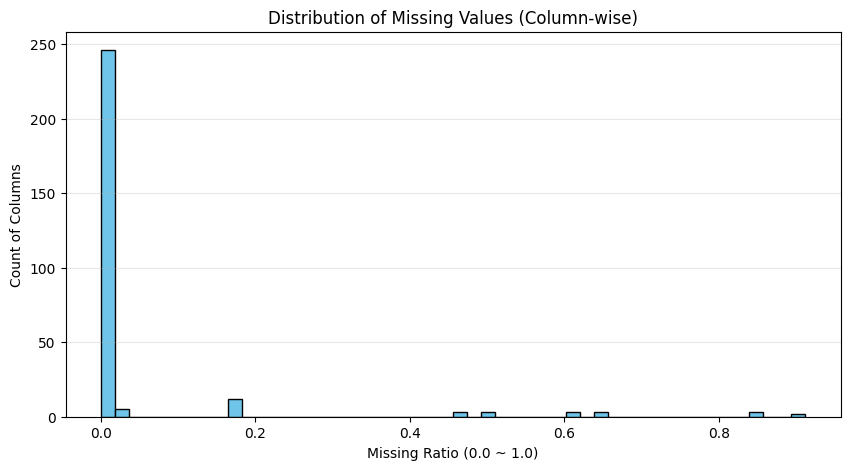

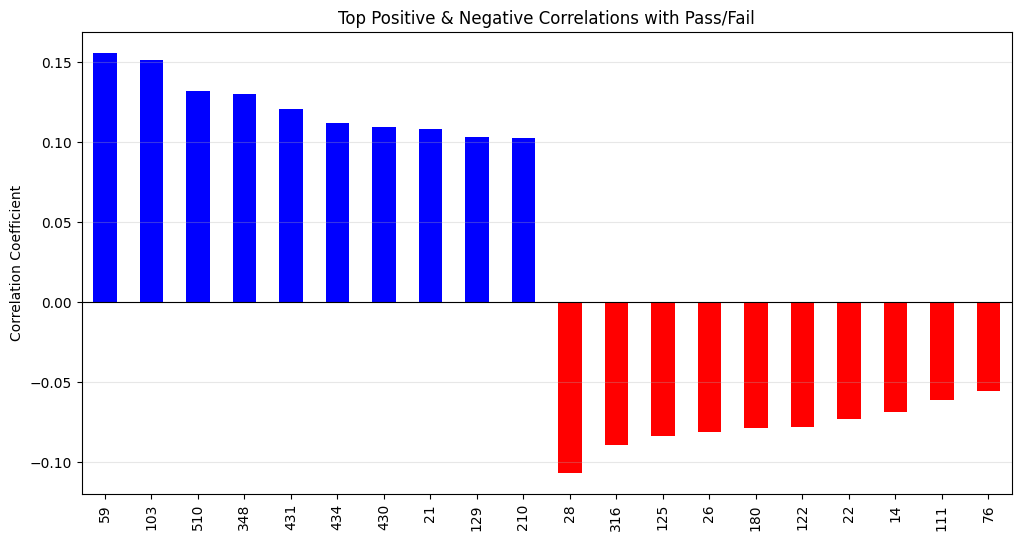

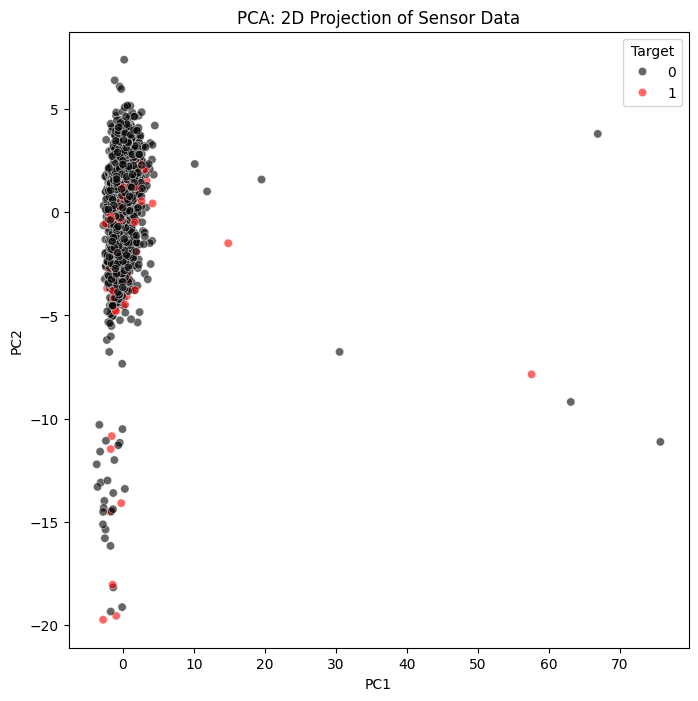

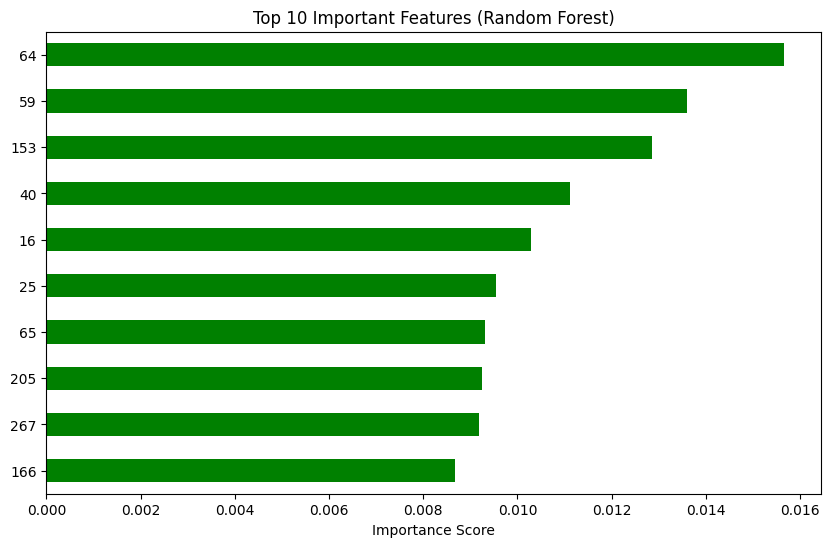

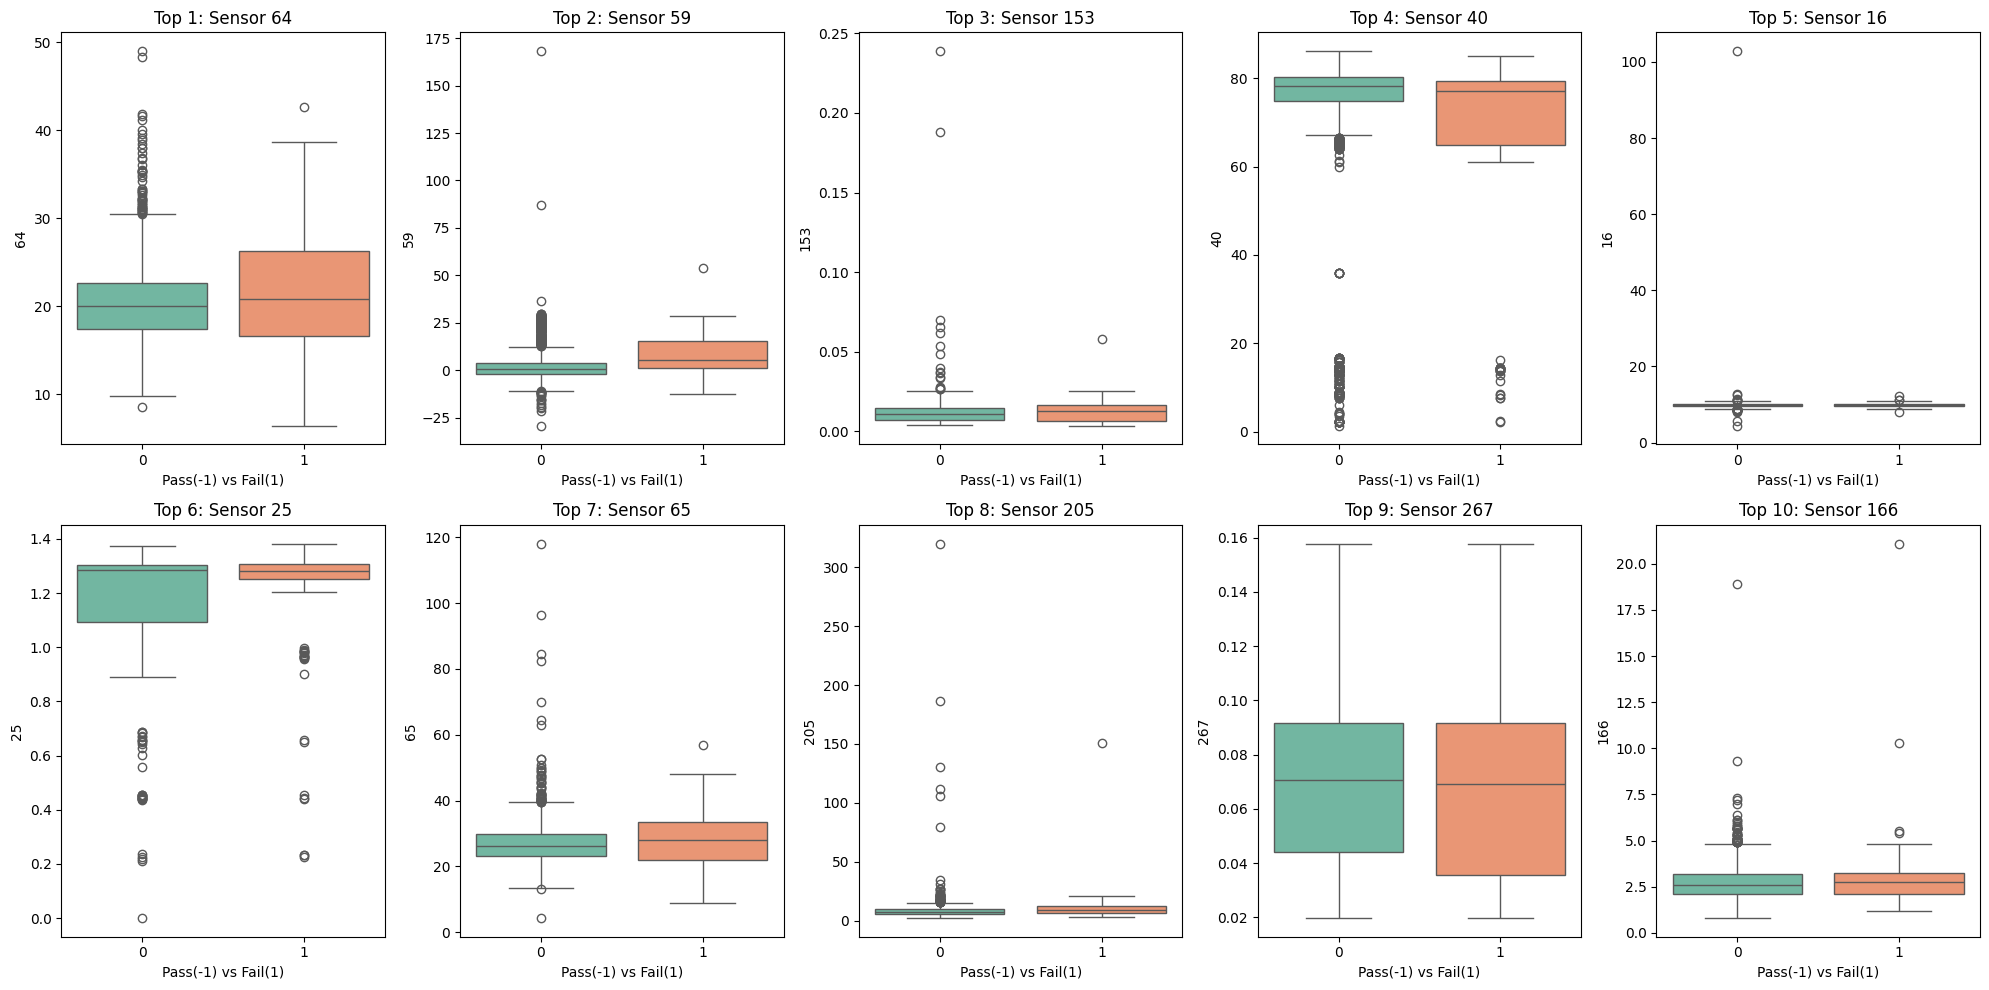

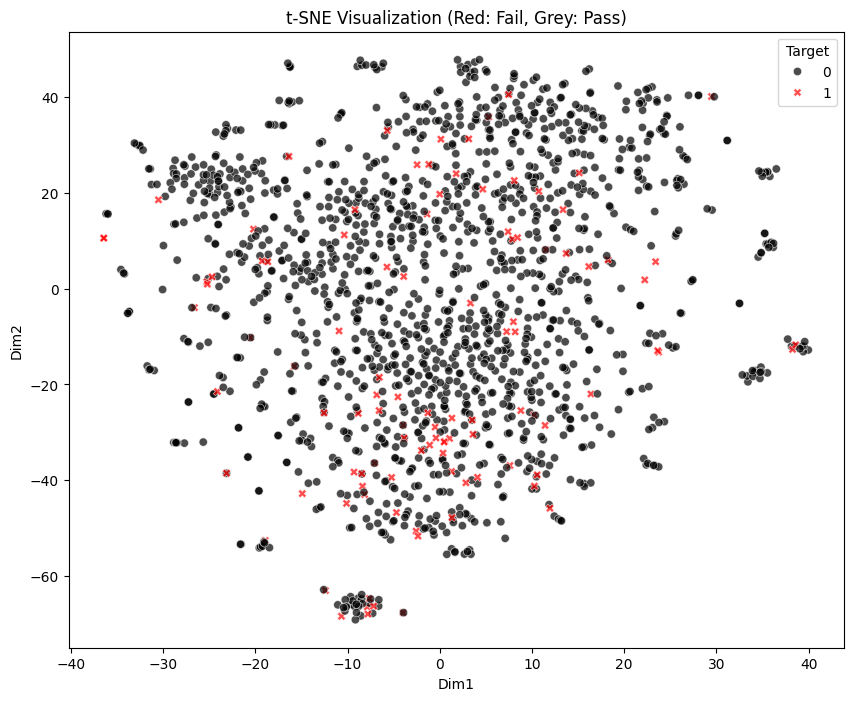

<Figure size 1200x1000 with 0 Axes>

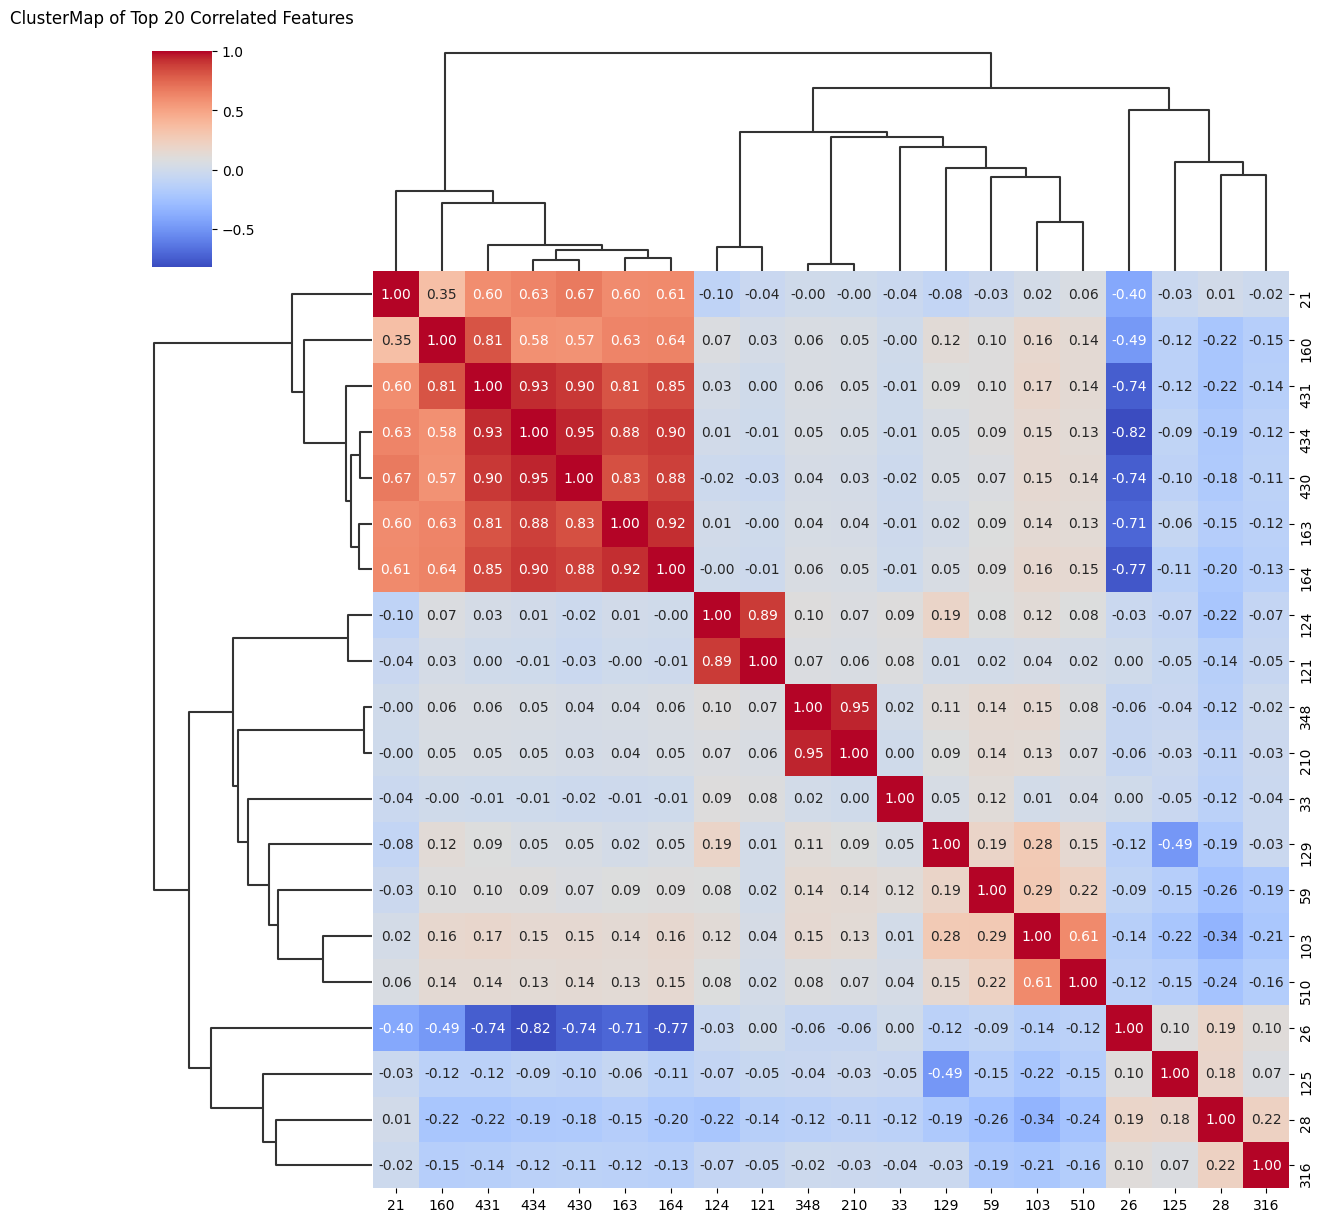

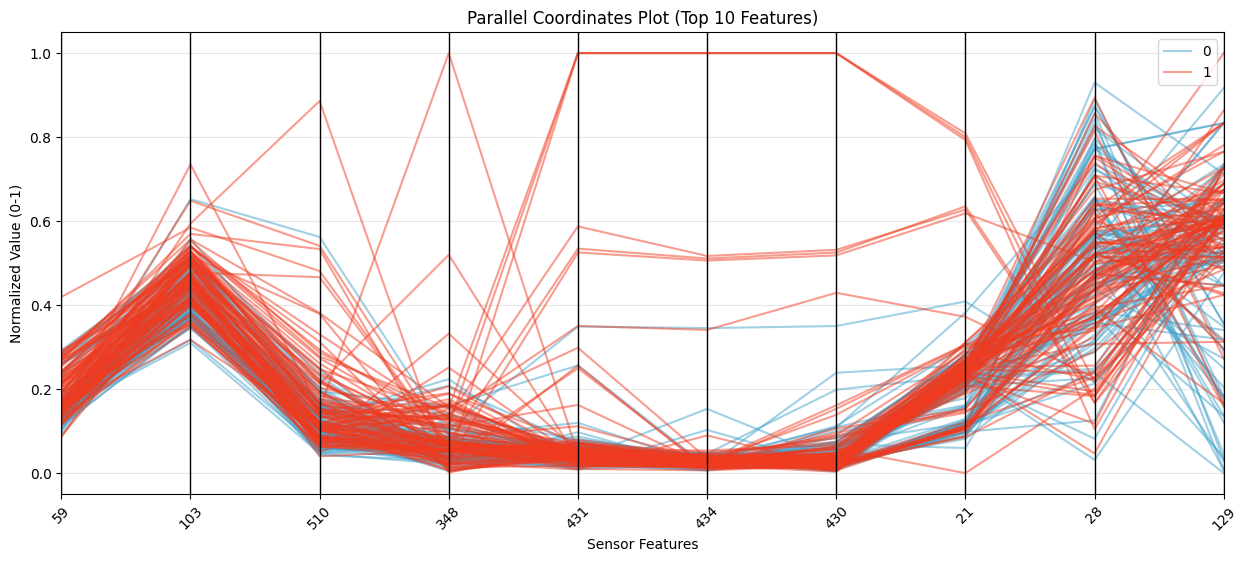

In [25]:
X = df.drop(columns=['Pass/Fail'])
y = df['Pass/Fail']

# [전략 1] 결측치 비율 분포 (Large Scale 대응)
missing_ratio = X.isnull().mean()
plt.figure(figsize=(10, 5))
plt.hist(missing_ratio, bins=50, color='#6EC5E9', edgecolor='black')
plt.title('Distribution of Missing Values (Column-wise)')
plt.xlabel('Missing Ratio (0.0 ~ 1.0)')
plt.ylabel('Count of Columns')
plt.grid(axis='y', alpha=0.3)
plt.savefig('missing_values_hist.png') # 결과 저장
plt.show()

# [전략 2] 타겟(Pass/Fail)과 상관관계가 높은 Top 센서 추출
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

correlations = X_imputed.corrwith(y)
top_pos = correlations.nlargest(10)  # 양의 상관관계 Top 10
top_neg = correlations.nsmallest(10) # 음의 상관관계 Top 10
top_corr = pd.concat([top_pos, top_neg])

plt.figure(figsize=(12, 6))
colors = ['red' if x < 0 else 'blue' for x in top_corr.values]
top_corr.plot(kind='bar', color=colors)
plt.title('Top Positive & Negative Correlations with Pass/Fail')
plt.ylabel('Correlation Coefficient')
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y', alpha=0.3)
plt.show()

# [전략 3] PCA 차원 축소 시각화 (590차원 -> 2차원)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Target'] = y.values

plt.figure(figsize=(8, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Target', 
                alpha=0.6, palette={-1: 'blue', 1: 'red'})
plt.title('PCA: 2D Projection of Sensor Data')
plt.show()

# [전략 4] 랜덤 포레스트 기반 중요 변수(Feature Importance) 추출
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_imputed, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.nlargest(10)

plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind='barh', color='green')
plt.title('Top 10 Important Features (Random Forest)')
plt.xlabel('Importance Score')
plt.show()

# [전략 5] Top 10 중요 변수의 분포 상세 비교 (Boxplot)
top_10_cols = top_features.index[:10]

fig, axes = plt.subplots(2, 5, figsize=(20, 10)) 
axes = axes.flatten() 

for i, col in enumerate(top_10_cols):
    sns.boxplot(x=y, y=X_imputed[col], ax=axes[i], palette='Set2')
    axes[i].set_title(f'Top {i+1}: Sensor {col}')
    axes[i].set_xlabel('Pass(-1) vs Fail(1)')

plt.tight_layout()
plt.show()

# [전략 6] t-SNE 시각화 (비선형 차원 축소)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 속도를 위해 perplexity=30, iter=1000 설정
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(data=X_tsne, columns=['Dim1', 'Dim2'])
tsne_df['Target'] = y.values

plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='Target', 
                palette={-1: 'lightgrey', 1: 'red'}, alpha=0.7, style='Target')
plt.title('t-SNE Visualization (Red: Fail, Grey: Pass)')
plt.show()

# [전략 7] Top 20 센서 간의 클러스터맵 (변수 간 관계 파악)
# ---------------------------------------------------------
# 모든 변수를 다 그리면 너무 복잡하므로, 타겟과 상관관계 높은 Top 20만 선정
correlations = X_imputed.corrwith(y).abs()
top_20_cols = correlations.nlargest(20).index
X_top20 = X_imputed[top_20_cols]

# 변수 간의 상관관계 계산
corr_matrix = X_top20.corr()

plt.figure(figsize=(12, 10))
sns.clustermap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
               figsize=(12, 12), tree_kws=dict(linewidths=1.5))
plt.title('ClusterMap of Top 20 Correlated Features', pad=20)
plt.show()

# [전략 8] 평행 좌표 그래프 (Parallel Coordinates)
# 값의 범위가 다르면 비교가 불가능하므로 Min-Max Scaling 필수
minmax_scaler = MinMaxScaler()
X_norm = pd.DataFrame(minmax_scaler.fit_transform(X_imputed), columns=X.columns)

# Top 10 중요한 변수만 뽑아서 흐름 비교
top_10_cols = correlations.nlargest(10).index
plot_df = X_norm[top_10_cols].copy()
plot_df['Target'] = y.values

# 시각화 가독성을 위해 데이터 샘플링 (Fail은 전부 포함, Pass는 100개만 샘플링)
df_fail = plot_df[plot_df['Target'] == 1]
df_pass = plot_df[plot_df['Target'] == 0].sample(n=100, random_state=42)
final_plot_df = pd.concat([df_pass, df_fail])

plt.figure(figsize=(15, 6))
pd.plotting.parallel_coordinates(final_plot_df, 'Target', color=('#43a2ca', '#f03b20'), alpha=0.5)
plt.title('Parallel Coordinates Plot (Top 10 Features)')
plt.xlabel('Sensor Features')
plt.ylabel('Normalized Value (0-1)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()